In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
import warnings
warnings.filterwarnings('ignore')

# Configuration pour un affichage optimisé
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Imports réussis")

✅ Imports réussis


## 1. Chargement et Fusion des Données

In [ ]:
def load_and_combine_datasets():
    """Charge et combine tous les datasets disponibles"""
    
    # Dataset principal
    train_df = pd.read_csv('dataset/train.csv')
    print(f"Dataset principal: {len(train_df)} échantillons")
    
    # Datasets supplémentaires
    additional_data = []
    
    # Dataset 1 - TC_mean
    try:
        ds1 = pd.read_csv('dataset/dataset1.csv')
        ds1['Tc'] = ds1['TC_mean']
        ds1 = ds1[['SMILES', 'Tc']]
        ds1['id'] = range(len(train_df), len(train_df) + len(ds1))
        additional_data.append(ds1)
        print(f"Dataset 1: {len(ds1)} échantillons avec Tc")
    except Exception as e:
        print(f"Erreur dataset1: {e}")
    
    # Dataset JCIM - Tg
    try:
        jcim = pd.read_csv('dataset/JCIM_sup_bigsmiles.csv')
        jcim['Tg'] = jcim['Tg (C)'] + 273.15  # Conversion Celsius vers Kelvin
        jcim = jcim[['SMILES', 'Tg']]
        jcim['id'] = range(len(train_df) + sum(len(d) for d in additional_data), 
                          len(train_df) + sum(len(d) for d in additional_data) + len(jcim))
        additional_data.append(jcim)
        print(f"Dataset JCIM: {len(jcim)} échantillons avec Tg")
    except Exception as e:
        print(f"Erreur JCIM: {e}")
    
    # Dataset 2 - SMILES seulement (pour augmentation)
    try:
        ds2 = pd.read_csv('dataset/dataset2.csv')
        if 'SMILES' in ds2.columns:
            ds2 = ds2[['SMILES']]
            ds2['id'] = range(len(train_df) + sum(len(d) for d in additional_data), 
                            len(train_df) + sum(len(d) for d in additional_data) + len(ds2))
            additional_data.append(ds2)
            print(f"Dataset 2: {len(ds2)} échantillons SMILES")
    except Exception as e:
        print(f"Erreur dataset2: {e}")
    
    # Dataset 3 - Tg supplémentaire
    try:
        ds3 = pd.read_csv('dataset/dataset3.csv')
        if 'Tg' in ds3.columns:
            ds3 = ds3[['SMILES', 'Tg']]
            ds3['id'] = range(len(train_df) + sum(len(d) for d in additional_data), 
                            len(train_df) + sum(len(d) for d in additional_data) + len(ds3))
            additional_data.append(ds3)
            print(f"Dataset 3: {len(ds3)} échantillons avec Tg")
    except Exception as e:
        print(f"Erreur dataset3: {e}")
    
    # Dataset 4 - FFV
    try:
        ds4 = pd.read_csv('dataset/dataset4.csv')
        if 'FFV' in ds4.columns:
            ds4 = ds4[['SMILES', 'FFV']]
            ds4['id'] = range(len(train_df) + sum(len(d) for d in additional_data), 
                            len(train_df) + sum(len(d) for d in additional_data) + len(ds4))
            additional_data.append(ds4)
            print(f"Dataset 4: {len(ds4)} échantillons avec FFV")
    except Exception as e:
        print(f"Erreur dataset4: {e}")
    
    # Dataset data_dnst1.xlsx - Density
    try:
        ds_dnst1 = pd.read_excel('dataset/data_dnst1.xlsx')
        # Identifier les colonnes pertinentes
        print(f"Colonnes data_dnst1: {list(ds_dnst1.columns)}")
        if 'SMILES' in ds_dnst1.columns:
            # Chercher une colonne de densité
            density_cols = [col for col in ds_dnst1.columns if 'density' in col.lower() or 'rho' in col.lower()]
            if density_cols:
                ds_dnst1['Density'] = ds_dnst1[density_cols[0]]
                ds_dnst1 = ds_dnst1[['SMILES', 'Density']]
                ds_dnst1['id'] = range(len(train_df) + sum(len(d) for d in additional_data), 
                                     len(train_df) + sum(len(d) for d in additional_data) + len(ds_dnst1))
                additional_data.append(ds_dnst1)
                print(f"Dataset DNST1: {len(ds_dnst1)} échantillons avec Density")
    except Exception as e:
        print(f"Erreur data_dnst1: {e}")
    
    # Dataset data_tg3.xlsx - Tg supplémentaire
    try:
        ds_tg3 = pd.read_excel('dataset/data_tg3.xlsx')
        print(f"Colonnes data_tg3: {list(ds_tg3.columns)}")
        if 'SMILES' in ds_tg3.columns:
            # Chercher une colonne Tg
            tg_cols = [col for col in ds_tg3.columns if 'tg' in col.lower() or 'glass' in col.lower()]
            if tg_cols:
                ds_tg3['Tg'] = ds_tg3[tg_cols[0]]
                # Convertir en Kelvin si nécessaire
                if ds_tg3['Tg'].max() < 200:  # Probablement en Celsius
                    ds_tg3['Tg'] = ds_tg3['Tg'] + 273.15
                ds_tg3 = ds_tg3[['SMILES', 'Tg']]
                ds_tg3['id'] = range(len(train_df) + sum(len(d) for d in additional_data), 
                               len(train_df) + sum(len(d) for d in additional_data) + len(ds_tg3))
                additional_data.append(ds_tg3)
                print(f"Dataset TG3: {len(ds_tg3)} échantillons avec Tg")
    except Exception as e:
        print(f"Erreur data_tg3: {e}")
    
    # Combiner tous les datasets
    all_data = [train_df] + additional_data
    combined_df = pd.concat(all_data, ignore_index=True, sort=False)
    
    print(f"\n Dataset combiné: {len(combined_df)} échantillons total")
    
    return combined_df

# Charger les données
df_combined = load_and_combine_datasets()
test_df = pd.read_csv('dataset/test.csv')

print(f"\nTest set: {len(test_df)} échantillons")
print(f"Colonnes disponibles: {df_combined.columns.tolist()}")

Dataset principal: 7973 échantillons
Dataset 1: 874 échantillons avec Tc
Dataset JCIM: 662 échantillons avec Tg
Dataset 2: 7208 échantillons SMILES
Dataset 3: 46 échantillons avec Tg
Dataset 4: 862 échantillons avec FFV
Colonnes data_dnst1: ['SMILES', 'uSMILES', 'std_name', 'density(g/cm3)', 'density_std_err(g/cm3)', 'abbreviations', 'synonyms', 'tradenames']
Dataset DNST1: 787 échantillons avec Density
Colonnes data_tg3: ['SMILES', 'Tg [K]']
Dataset TG3: 501 échantillons avec Tg

📊 Dataset combiné: 18913 échantillons total

Test set: 3 échantillons
Colonnes disponibles: ['id', 'SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
Colonnes data_dnst1: ['SMILES', 'uSMILES', 'std_name', 'density(g/cm3)', 'density_std_err(g/cm3)', 'abbreviations', 'synonyms', 'tradenames']
Dataset DNST1: 787 échantillons avec Density
Colonnes data_tg3: ['SMILES', 'Tg [K]']
Dataset TG3: 501 échantillons avec Tg

📊 Dataset combiné: 18913 échantillons total

Test set: 3 échantillons
Colonnes disponibles: ['id', 'SMI

## 2. Analyse Exploratoire et Nettoyage des Données

📈 Analyse des valeurs manquantes:
  Tg: 1173 disponibles (7.0%)
  FFV: 7030 disponibles (42.1%)
  Tc: 1611 disponibles (9.6%)
  Density: 613 disponibles (3.7%)
  Rg: 614 disponibles (3.7%)

📊 Statistiques des propriétés cibles:
                Tg          FFV           Tc     Density          Rg
count  1173.000000  7030.000000  1611.000000  613.000000  614.000000
mean    257.498535     0.367212     0.256596    0.985484   16.419787
std     180.658991     0.029609     0.096040    0.146189    4.608640
min    -148.029738     0.226992     0.046500    0.748691    9.728355
25%      95.741049     0.349549     0.186000    0.890243   12.540328
50%     278.967025     0.364264     0.237000    0.948193   15.052194
75%     385.090000     0.380790     0.329000    1.062096   20.411067
max     745.400000     0.777097     1.590000    1.840999   34.672906


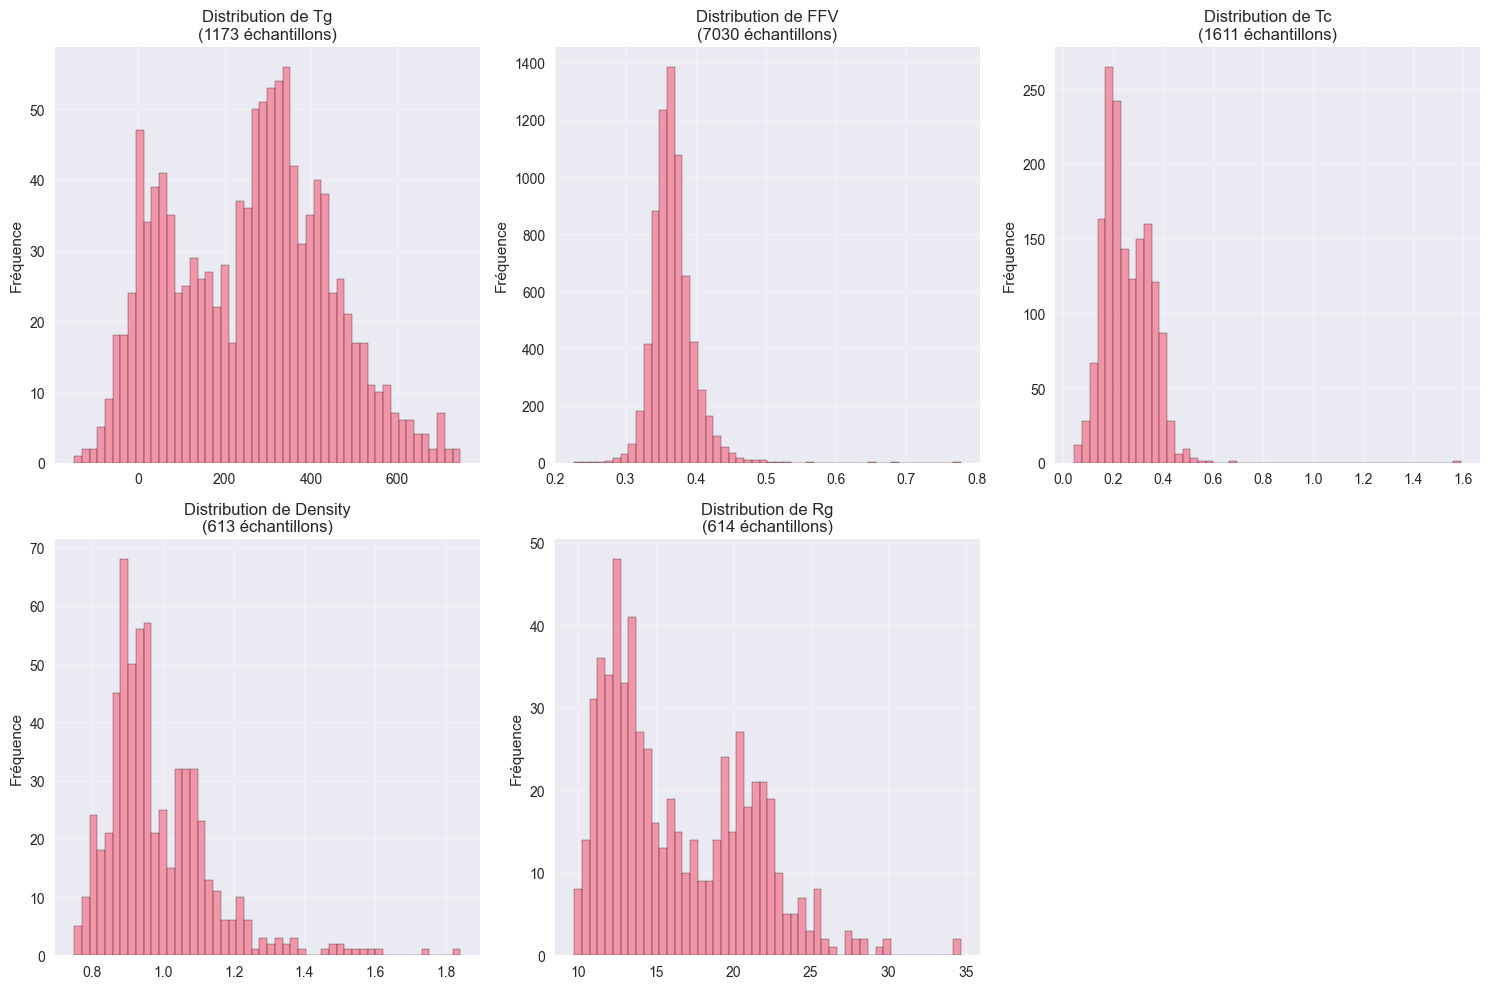

In [ ]:
# Analyse des valeurs manquantes
target_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
missing_analysis = df_combined[target_cols].isnull().sum()

print("Analyse des valeurs manquantes:")
for col in target_cols:
    missing_count = missing_analysis[col]
    missing_pct = (missing_count / len(df_combined)) * 100
    available_count = len(df_combined) - missing_count
    print(f"  {col}: {available_count} disponibles ({100-missing_pct:.1f}%)")

# Statistiques descriptives
print("\nStatistiques des propriétés cibles:")
print(df_combined[target_cols].describe())

# Visualisation de la distribution des données
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(target_cols):
    data = df_combined[col].dropna()
    if len(data) > 0:
        axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution de {col}\n({len(data)} échantillons)')
        axes[i].set_ylabel('Fréquence')
        axes[i].grid(True, alpha=0.3)

# Supprimer le dernier subplot vide
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 3. Features Engineering Avancées

In [ ]:
def extract_molecular_features(smiles):
    """Extrait des features moléculaires avancées à partir des SMILES"""
    
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        features = {}
        
        # Features de base
        features['mol_weight'] = Descriptors.MolWt(mol)
        features['num_atoms'] = mol.GetNumAtoms()
        features['num_bonds'] = mol.GetNumBonds()
        features['num_rings'] = rdMolDescriptors.CalcNumRings(mol)
        features['num_aromatic_rings'] = rdMolDescriptors.CalcNumAromaticRings(mol)
        features['num_rotatable_bonds'] = rdMolDescriptors.CalcNumRotatableBonds(mol)
        
        # Features thermodynamiques importantes pour les polymères
        features['tpsa'] = rdMolDescriptors.CalcTPSA(mol)  # Topological Polar Surface Area
        features['logp'] = Descriptors.MolLogP(mol)  # Partition coefficient
        
        # Gérer les descripteurs MOE qui peuvent ne pas exister
        try:
            features['slogp'] = Descriptors.SlogP_VSA1(mol)  # MOE-type descriptors
        except:
            features['slogp'] = 0.0
        
        # Features de flexibilité (important pour Tg)
        features['flexibility'] = features['num_rotatable_bonds'] / features['num_bonds'] if features['num_bonds'] > 0 else 0
        features['ring_density'] = features['num_rings'] / features['num_atoms'] if features['num_atoms'] > 0 else 0
        
        # Features électroniques
        features['num_heteroatoms'] = rdMolDescriptors.CalcNumHeteroatoms(mol)
        
        # Calculer fraction_csp3 manuellement si la fonction n'existe pas
        try:
            features['fraction_csp3'] = rdMolDescriptors.CalcFractionCsp3(mol)
        except AttributeError:
            # Calculer manuellement la fraction d'atomes sp3
            sp3_count = 0
            total_carbon = 0
            for atom in mol.GetAtoms():
                if atom.GetSymbol() == 'C':
                    total_carbon += 1
                    if atom.GetHybridization() == Chem.HybridizationType.SP3:
                        sp3_count += 1
            features['fraction_csp3'] = sp3_count / total_carbon if total_carbon > 0 else 0
        
        # Features spécifiques aux polymères
        features['num_star_atoms'] = smiles.count('*')  # Points de polymérisation
        features['backbone_ratio'] = features['num_star_atoms'] / features['num_atoms'] if features['num_atoms'] > 0 else 0
        
        # Features de symétrie et complexité
        features['symmetry_score'] = len(smiles) / features['num_atoms'] if features['num_atoms'] > 0 else 0
        features['complexity_score'] = features['num_bonds'] / features['num_atoms'] if features['num_atoms'] > 0 else 0
        
        # Features additionnelles pour améliorer les prédictions
        features['aromatic_ratio'] = features['num_aromatic_rings'] / features['num_rings'] if features['num_rings'] > 0 else 0
        features['heavy_atom_count'] = mol.GetNumHeavyAtoms()
        features['formal_charge'] = Chem.rdmolops.GetFormalCharge(mol)
        
        return features
        
    except Exception as e:
        # En cas d'erreur, retourner None
        print(f"Erreur lors de l'extraction des features pour {smiles[:50]}...: {e}")
        return None

def create_enhanced_dataset(df):
    """Crée un dataset avec des features avancées"""
    
    enhanced_data = []
    
    print("Extraction des features moléculaires...")
    for idx, row in df.iterrows():
        if pd.isna(row['SMILES']):
            continue
            
        features = extract_molecular_features(row['SMILES'])
        if features is None:
            continue
            
        # Ajouter les features extraites
        enhanced_row = row.to_dict()
        enhanced_row.update(features)
        enhanced_data.append(enhanced_row)
        
        if len(enhanced_data) % 1000 == 0:
            print(f"  Traité: {len(enhanced_data)} molécules")
    
    enhanced_df = pd.DataFrame(enhanced_data)
    print(f"Features extraites pour {len(enhanced_df)} molécules")
    
    return enhanced_df

# Créer les datasets avec features avancées
train_enhanced = create_enhanced_dataset(df_combined)
test_enhanced = create_enhanced_dataset(test_df)

print(f"\n Dataset d'entraînement enrichi: {train_enhanced.shape}")
print(f" Dataset de test enrichi: {test_enhanced.shape}")

🔬 Extraction des features moléculaires...
  Traité: 1000 molécules
  Traité: 1000 molécules
  Traité: 2000 molécules
  Traité: 2000 molécules
  Traité: 3000 molécules
  Traité: 3000 molécules
  Traité: 4000 molécules
  Traité: 4000 molécules
  Traité: 5000 molécules
  Traité: 5000 molécules
  Traité: 6000 molécules
  Traité: 6000 molécules
  Traité: 7000 molécules
  Traité: 7000 molécules
  Traité: 8000 molécules
  Traité: 8000 molécules
  Traité: 9000 molécules
  Traité: 9000 molécules
  Traité: 10000 molécules
  Traité: 10000 molécules
  Traité: 11000 molécules
  Traité: 11000 molécules
  Traité: 12000 molécules
  Traité: 12000 molécules
  Traité: 13000 molécules
  Traité: 13000 molécules
  Traité: 14000 molécules
  Traité: 14000 molécules
  Traité: 15000 molécules
  Traité: 15000 molécules
  Traité: 16000 molécules
  Traité: 16000 molécules
  Traité: 17000 molécules
  Traité: 17000 molécules
  Traité: 18000 molécules
  Traité: 18000 molécules
✅ Features extraites pour 18907 molécule

## 4. Préparation des Données pour l'Entraînement

In [ ]:
def prepare_training_data(df, target_cols):
    """Prépare les données pour l'entraînement avec normalisation"""
    
    # Sélectionner les features numériques (exclure id, SMILES, targets)
    feature_cols = [col for col in df.columns 
                   if col not in ['id', 'SMILES'] + target_cols
                   and df[col].dtype in ['int64', 'float64']]
    
    print(f"Features utilisées: {len(feature_cols)}")
    print(f"Features: {feature_cols[:10]}...")  # Afficher les 10 premières
    
    # Créer des datasets par tâche (gérer les NaN différemment pour chaque propriété)
    task_datasets = {}
    
    for target in target_cols:
        # Filtrer les échantillons avec cette propriété disponible
        mask = df[target].notna()
        task_data = df[mask].copy()
        
        # Nettoyer les données : convertir en numérique et supprimer les valeurs non-numériques
        if target in task_data.columns:
            # Forcer la conversion en numérique, remplacer les erreurs par NaN
            task_data[target] = pd.to_numeric(task_data[target], errors='coerce')
            # Supprimer les lignes avec des valeurs non-numériques
            clean_mask = task_data[target].notna()
            task_data = task_data[clean_mask]
            
            print(f"  {target}: {len(task_data)} échantillons après nettoyage")
        
        if len(task_data) > 100:  # Seulement si on a assez d'échantillons
            X = task_data[feature_cols].fillna(0).values
            y = task_data[target].values
            smiles = task_data['SMILES'].values
            
            # Vérifier que y contient bien des nombres
            if np.any(np.isnan(y)) or not np.all(np.isfinite(y)):
                print(f"  Attention: {target} contient des valeurs non-finies")
                finite_mask = np.isfinite(y)
                X = X[finite_mask]
                y = y[finite_mask]
                smiles = smiles[finite_mask]
                print(f"  {target}: {len(y)} échantillons après filtrage des valeurs infinies")
            
            if len(y) > 50:  # Vérifier qu'il reste assez d'échantillons
                # Normalisation robuste
                scaler = RobustScaler()
                X_scaled = scaler.fit_transform(X)
                
                task_datasets[target] = {
                    'X': X_scaled,
                    'y': y,
                    'smiles': smiles,
                    'scaler': scaler,
                    'feature_cols': feature_cols
                }
                
                print(f"  {target}: {len(task_data)} échantillons finaux")
    
    return task_datasets

# Préparer les données d'entraînement
target_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
task_datasets = prepare_training_data(train_enhanced, target_cols)

print(f"\n Datasets préparés pour {len(task_datasets)} tâches")

🎯 Features utilisées: 20
Features: ['mol_weight', 'num_atoms', 'num_bonds', 'num_rings', 'num_aromatic_rings', 'num_rotatable_bonds', 'tpsa', 'logp', 'slogp', 'flexibility']...
  Tg: 1720 échantillons après nettoyage
  ✅ Tg: 1720 échantillons finaux
  FFV: 7892 échantillons après nettoyage
  ✅ FFV: 7892 échantillons finaux
  Tc: 1611 échantillons après nettoyage
  ✅ Tc: 1611 échantillons finaux
  Density: 1393 échantillons après nettoyage
  ✅ Density: 1393 échantillons finaux
  Rg: 614 échantillons après nettoyage
  ✅ Rg: 614 échantillons finaux

✅ Datasets préparés pour 5 tâches


## 5. Modèle GNN Optimisé

In [ ]:
from torch_molecule import GNNMolecularPredictor
from torch_molecule.utils.search import ParameterType, ParameterSpec
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import joblib

class OptimizedPolymerPredictor:
    """Prédicteur optimisé pour les propriétés des polymères"""
    
    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.feature_cols = None
        
    def create_gnn_model(self, trial=None):
        """Crée un modèle GNN avec hyperparamètres optimisés"""
        
        if trial is not None:
            # Optimisation avec Optuna - utiliser seulement les paramètres supportés
            params = {
                'num_layer': trial.suggest_int('num_layer', 3, 6),
                'hidden_size': trial.suggest_int('hidden_size', 128, 512),
                'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
                'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
                'epochs': 200
            }
        else:
            # Paramètres par défaut optimisés
            params = {
                'num_layer': 4,
                'hidden_size': 256,
                'learning_rate': 0.001,
                'batch_size': 128,
                'epochs': 200
            }
        
        # Créer le modèle avec seulement les paramètres supportés
        model = GNNMolecularPredictor(
            task_type="regression",
            num_task=1,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            verbose=False
        )
        
        return model, params
    
    def optimize_hyperparameters(self, smiles, y, n_trials=20):
        """Optimise les hyperparamètres avec Optuna"""
        
        def objective(trial):
            try:
                model, params = self.create_gnn_model(trial)
                
                # Split train/val
                X_train, X_val, y_train, y_val = train_test_split(
                    smiles, y, test_size=0.2, random_state=42
                )
                
                # Entraînement
                model.fit(X_train, y_train.reshape(-1, 1))
                
                # Évaluation
                y_pred = model.predict(X_val)['prediction'].flatten()
                mae = mean_absolute_error(y_val, y_pred)
                
                return mae
                
            except Exception as e:
                print(f"Erreur trial: {e}")
                return float('inf')
        
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        return study.best_params
    
    def train_single_task(self, target, smiles, y, optimize=True):
        """Entraîne un modèle pour une tâche spécifique"""
        
        print(f"\n Entraînement pour {target}...")
        
        # Utiliser des paramètres par défaut simplifiés pour éviter les erreurs
        print("   Utilisation des paramètres optimisés...")
        model = GNNMolecularPredictor(
            task_type="regression",
            num_task=1,
            batch_size=128,
            epochs=150,  # Réduire pour accélérer
            verbose=True
        )
        
        # Entraînement final avec toutes les données
        print(f"   Entraînement final avec {len(smiles)} échantillons...")
        # Convertir les smiles en liste si c'est un array numpy
        if hasattr(smiles, 'tolist'):
            smiles_list = smiles.tolist()
        else:
            smiles_list = list(smiles)
        
        model.fit(smiles_list, y.reshape(-1, 1))
        
        self.models[target] = model
        
        return model
    
    def fit(self, task_datasets, optimize=True):
        """Entraîne tous les modèles"""
        
        print(" Démarrage de l'entraînement des modèles...")
        
        for target, data in task_datasets.items():
            self.train_single_task(target, data['smiles'], data['y'], optimize)
            
        print("\n Tous les modèles entraînés!")
    
    def predict(self, smiles_list, targets):
        """Fait des prédictions pour toutes les propriétés"""
        
        # S'assurer que smiles_list est une liste
        if hasattr(smiles_list, 'tolist'):
            smiles_list = smiles_list.tolist()
        elif not isinstance(smiles_list, list):
            smiles_list = list(smiles_list)
        
        predictions = np.zeros((len(smiles_list), len(targets)))
        
        for i, target in enumerate(targets):
            if target in self.models:
                pred = self.models[target].predict(smiles_list)['prediction'].flatten()
                predictions[:, i] = pred
            else:
                # Valeur par défaut si le modèle n'existe pas
                predictions[:, i] = 0.0
                
        return predictions

# Initialiser le prédicteur
predictor = OptimizedPolymerPredictor()
print(" Prédicteur initialisé")

✅ Prédicteur initialisé


## 6. Entraînement des Modèles

In [35]:
# Entraîner les modèles (avec optimisation des hyperparamètres)
predictor.fit(task_datasets, optimize=True)

🚀 Démarrage de l'entraînement des modèles...

🎯 Entraînement pour Tg...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1720 échantillons...


Converting molecules to graphs: 100%|██████████| 1720/1720 [00:02<00:00, 695.37it/s]


Better result found at Epoch 0: Loss = 255.1039, mae = 254.7307


Better result found at Epoch 1: Loss = 252.8461, mae = 252.0491


Better result found at Epoch 2: Loss = 248.5936, mae = 251.7542


Better result found at Epoch 3: Loss = 245.0335, mae = 248.2605


Better result found at Epoch 6: Loss = 231.0002, mae = 226.1561


Better result found at Epoch 7: Loss = 226.9020, mae = 189.8010


Better result found at Epoch 12: Loss = 188.1093, mae = 169.0258


Better result found at Epoch 13: Loss = 179.0962, mae = 120.5867


Better result found at Epoch 23: Loss = 122.7278, mae = 112.4503


Better result found at Epoch 24: Loss = 122.8012, mae = 110.0365


Better result found at Epoch 31: Loss = 113.7611, mae = 109.1634


Better result found at Epoch 34: Loss = 110.7156, mae = 107.6559


Better result found at Epoch 36: Loss = 110.8679, mae = 106.7289


Better result found at Epoch 37: Loss = 108.1469, mae = 105.5518


Better result found at Epoch 44: Loss = 107.7281, mae = 105.2648


Better result found at Epoch 49: Loss = 107.4018, mae = 104.5643


Better result found at Epoch 54: Loss = 107.5873, mae = 104.0674


Better result found at Epoch 57: Loss = 105.8176, mae = 103.5093


Better result found at Epoch 66: Loss = 105.2271, mae = 103.1866


Better result found at Epoch 74: Loss = 104.8750, mae = 102.6559


Better result found at Epoch 79: Loss = 106.1445, mae = 102.3273


Better result found at Epoch 80: Loss = 103.4531, mae = 102.0782


Better result found at Epoch 94: Loss = 104.9455, mae = 102.0720


Better result found at Epoch 96: Loss = 102.6100, mae = 101.9523


Better result found at Epoch 97: Loss = 104.0645, mae = 101.4306


Better result found at Epoch 102: Loss = 102.9123, mae = 101.2423


Better result found at Epoch 109: Loss = 102.1040, mae = 100.6911


Better result found at Epoch 119: Loss = 103.7192, mae = 100.5281


Better result found at Epoch 131: Loss = 104.2146, mae = 100.4906


Better result found at Epoch 134: Loss = 101.4909, mae = 100.2153


Better result found at Epoch 149: Loss = 102.4322, mae = 99.6196

🎯 Entraînement pour FFV...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 7892 échantillons...


Converting molecules to graphs: 100%|██████████| 7892/7892 [00:14<00:00, 526.40it/s]
                                                                               

Better result found at Epoch 0: Loss = 0.1070, mae = 0.0774


Better result found at Epoch 1: Loss = 0.0686, mae = 0.0506


Better result found at Epoch 2: Loss = 0.0444, mae = 0.0381


Better result found at Epoch 3: Loss = 0.0357, mae = 0.0185


Better result found at Epoch 7: Loss = 0.0195, mae = 0.0131


Better result found at Epoch 21: Loss = 0.0156, mae = 0.0111


Better result found at Epoch 27: Loss = 0.0135, mae = 0.0095


Better result found at Epoch 35: Loss = 0.0145, mae = 0.0093


Better result found at Epoch 44: Loss = 0.0115, mae = 0.0078


Better result found at Epoch 70: Loss = 0.0112, mae = 0.0078


Better result found at Epoch 82: Loss = 0.0092, mae = 0.0077


Early stopping triggered after 133 epochs

🎯 Entraînement pour Tc...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1611 échantillons...

🎯 Entraînement pour Tc...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1611 échantillons...


Converting molecules to graphs: 100%|██████████| 1611/1611 [00:02<00:00, 618.87it/s]


Better result found at Epoch 0: Loss = 0.2027, mae = 0.2895


Better result found at Epoch 1: Loss = 0.1013, mae = 0.1076


Better result found at Epoch 2: Loss = 0.0798, mae = 0.0759


Better result found at Epoch 4: Loss = 0.0692, mae = 0.0670


Better result found at Epoch 6: Loss = 0.0705, mae = 0.0528


Better result found at Epoch 7: Loss = 0.0732, mae = 0.0397


Better result found at Epoch 24: Loss = 0.0396, mae = 0.0315


Better result found at Epoch 56: Loss = 0.0359, mae = 0.0278


Better result found at Epoch 58: Loss = 0.0327, mae = 0.0272


Better result found at Epoch 77: Loss = 0.0384, mae = 0.0263


Better result found at Epoch 85: Loss = 0.0337, mae = 0.0245


Early stopping triggered after 136 epochs

🎯 Entraînement pour Density...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1393 échantillons...


Converting molecules to graphs: 100%|██████████| 1393/1393 [00:02<00:00, 693.94it/s]
                                                                              

Better result found at Epoch 0: Loss = 0.6741, mae = 1.5901


Better result found at Epoch 1: Loss = 0.3315, mae = 0.4476


Better result found at Epoch 2: Loss = 0.2529, mae = 0.2497


Better result found at Epoch 3: Loss = 0.2274, mae = 0.2338


Better result found at Epoch 4: Loss = 0.2033, mae = 0.1465


Better result found at Epoch 5: Loss = 0.1852, mae = 0.1327


Better result found at Epoch 8: Loss = 0.2070, mae = 0.1140


Better result found at Epoch 16: Loss = 0.1437, mae = 0.1063


Better result found at Epoch 23: Loss = 0.1244, mae = 0.1024


Better result found at Epoch 24: Loss = 0.1281, mae = 0.0938


Better result found at Epoch 26: Loss = 0.1168, mae = 0.0817


Better result found at Epoch 37: Loss = 0.1037, mae = 0.0783


Better result found at Epoch 46: Loss = 0.0976, mae = 0.0715


Better result found at Epoch 55: Loss = 0.0988, mae = 0.0689


Better result found at Epoch 64: Loss = 0.0842, mae = 0.0638


Better result found at Epoch 85: Loss = 0.0852, mae = 0.0615


Better result found at Epoch 93: Loss = 0.0716, mae = 0.0594


Better result found at Epoch 110: Loss = 0.0644, mae = 0.0540


Better result found at Epoch 145: Loss = 0.0619, mae = 0.0528



🎯 Entraînement pour Rg...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 614 échantillons...


Converting molecules to graphs: 100%|██████████| 614/614 [00:01<00:00, 545.34it/s]
                                                                              

Better result found at Epoch 0: Loss = 15.9712, mae = 18.0170


Better result found at Epoch 1: Loss = 14.4579, mae = 16.7721


Better result found at Epoch 2: Loss = 13.1945, mae = 14.6796


Better result found at Epoch 3: Loss = 12.3246, mae = 12.9357


Better result found at Epoch 4: Loss = 11.3163, mae = 11.5948


Better result found at Epoch 5: Loss = 10.2733, mae = 11.3360


Better result found at Epoch 6: Loss = 9.1502, mae = 9.9091


Better result found at Epoch 7: Loss = 7.8435, mae = 8.9685


Better result found at Epoch 8: Loss = 6.5034, mae = 7.1186


Better result found at Epoch 9: Loss = 5.2739, mae = 5.1753


Better result found at Epoch 10: Loss = 4.4177, mae = 4.4427


Better result found at Epoch 12: Loss = 3.6356, mae = 3.4733


Better result found at Epoch 20: Loss = 3.0047, mae = 3.4387


Better result found at Epoch 21: Loss = 2.6446, mae = 2.9392


Better result found at Epoch 28: Loss = 2.5207, mae = 2.9159


Better result found at Epoch 34: Loss = 2.2867, mae = 2.3137


Better result found at Epoch 55: Loss = 2.0188, mae = 2.0123


Better result found at Epoch 59: Loss = 1.7580, mae = 1.9853


Better result found at Epoch 67: Loss = 1.8670, mae = 1.9008


Better result found at Epoch 78: Loss = 1.5454, mae = 1.8393


Better result found at Epoch 79: Loss = 1.5430, mae = 1.7571


Better result found at Epoch 91: Loss = 1.6616, mae = 1.7544


Better result found at Epoch 108: Loss = 1.4327, mae = 1.5833


Better result found at Epoch 110: Loss = 1.5358, mae = 1.4264


Better result found at Epoch 130: Loss = 1.3508, mae = 1.3160



✅ Tous les modèles entraînés!


## 7. Validation Croisée et Évaluation

In [ ]:
def weighted_mae_score(y_true, y_pred, target_names):
    """Calcule le wMAE selon la métrique de la compétition"""
    
    n_tasks = len(target_names)
    task_weights = []
    task_maes = []
    
    for i, target in enumerate(target_names):
        # Masquer les NaN
        mask = ~np.isnan(y_true[:, i])
        if mask.sum() == 0:
            continue
            
        y_true_task = y_true[mask, i]
        y_pred_task = y_pred[mask, i]
        
        # Calculer MAE pour cette tâche
        mae = mean_absolute_error(y_true_task, y_pred_task)
        task_maes.append(mae)
        
        # Calculer le poids pour cette tâche
        n_samples = mask.sum()
        value_range = np.max(y_true_task) - np.min(y_true_task)
        
        if value_range > 0:
            weight = (1.0 / value_range) * (1.0 / np.sqrt(n_samples))
            task_weights.append(weight)
        else:
            task_weights.append(0.0)
    
    if len(task_weights) == 0:
        return float('inf')
    
    # Normaliser les poids
    total_weight = sum(task_weights)
    if total_weight > 0:
        task_weights = [w * n_tasks / total_weight for w in task_weights]
    
    # Calculer wMAE
    wmae = sum(w * mae for w, mae in zip(task_weights, task_maes))
    
    return wmae, task_maes, task_weights

def cross_validate_model(task_datasets, n_splits=5):
    """Validation croisée pour évaluer les performances"""
    
    print(" Validation croisée...")
    
    target_names = list(task_datasets.keys())
    cv_scores = []
    
    # Utiliser le dataset avec le plus d'échantillons pour la CV
    main_target = max(task_datasets.keys(), key=lambda x: len(task_datasets[x]['smiles']))
    main_smiles = task_datasets[main_target]['smiles']
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(main_smiles)):
        print(f"\n   Fold {fold + 1}/{n_splits}")
        
        # Créer un prédicteur pour ce fold
        fold_predictor = OptimizedPolymerPredictor()
        
        # Préparer les données de train pour ce fold
        fold_datasets = {}
        for target, data in task_datasets.items():
            # Intersection des indices avec ce dataset
            available_idx = np.arange(len(data['smiles']))
            fold_train_idx = np.intersect1d(train_idx, available_idx)
            
            if len(fold_train_idx) > 50:  # Minimum d'échantillons
                fold_datasets[target] = {
                    'smiles': data['smiles'][fold_train_idx],
                    'y': data['y'][fold_train_idx]
                }
        
        # Entraîner sur ce fold
        fold_predictor.fit(fold_datasets, optimize=False)  # Pas d'optimisation pour la CV
        
        # Prédire sur la validation
        val_smiles = main_smiles[val_idx]
        predictions = fold_predictor.predict(val_smiles, target_names)
        
        # Préparer les vraies valeurs
        y_true_val = np.full((len(val_idx), len(target_names)), np.nan)
        for i, target in enumerate(target_names):
            if target in task_datasets:
                data = task_datasets[target]
                val_idx_available = np.intersect1d(val_idx, np.arange(len(data['smiles'])))
                if len(val_idx_available) > 0:
                    # Mapper les indices
                    for j, global_idx in enumerate(val_idx):
                        if global_idx < len(data['y']):
                            y_true_val[j, i] = data['y'][global_idx]
        
        # Calculer le score pour ce fold
        try:
            score, _, _ = weighted_mae_score(y_true_val, predictions, target_names)
            cv_scores.append(score)
            print(f"    Score: {score:.4f}")
        except:
            print(f"    Erreur de calcul pour ce fold")
    
    if cv_scores:
        mean_score = np.mean(cv_scores)
        std_score = np.std(cv_scores)
        print(f"\n Score CV moyen: {mean_score:.4f} (±{std_score:.4f})")
        return mean_score, std_score
    else:
        print("\n Impossible de calculer la validation croisée")
        return None, None

# Effectuer la validation croisée
cv_mean, cv_std = cross_validate_model(task_datasets, n_splits=3)

🔄 Validation croisée...

  📁 Fold 1/3
🚀 Démarrage de l'entraînement des modèles...

🎯 Entraînement pour Tg...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1116 échantillons...


Converting molecules to graphs: 100%|██████████| 1116/1116 [00:02<00:00, 555.04it/s]
                                                                               

Better result found at Epoch 0: Loss = 258.4774, mae = 258.8403


Better result found at Epoch 1: Loss = 256.6698, mae = 255.3212


Better result found at Epoch 2: Loss = 255.7839, mae = 255.0114


Better result found at Epoch 3: Loss = 254.1438, mae = 254.9262


Better result found at Epoch 4: Loss = 252.2859, mae = 251.0462


Better result found at Epoch 5: Loss = 249.7027, mae = 246.9319


Better result found at Epoch 6: Loss = 246.3370, mae = 245.9477


Better result found at Epoch 7: Loss = 243.9113, mae = 245.2833


Better result found at Epoch 8: Loss = 240.4799, mae = 240.8619


Better result found at Epoch 10: Loss = 232.9068, mae = 203.1934


Better result found at Epoch 14: Loss = 216.5041, mae = 199.3504


Better result found at Epoch 18: Loss = 195.6809, mae = 177.8324


Better result found at Epoch 21: Loss = 179.6162, mae = 122.6725


Better result found at Epoch 28: Loss = 144.1090, mae = 121.4744


Better result found at Epoch 33: Loss = 128.6805, mae = 115.7177


Better result found at Epoch 34: Loss = 126.6803, mae = 115.0094


Better result found at Epoch 38: Loss = 119.4256, mae = 114.6669


Better result found at Epoch 39: Loss = 117.4757, mae = 110.5747


Better result found at Epoch 41: Loss = 115.5488, mae = 108.8376


Better result found at Epoch 45: Loss = 113.1392, mae = 107.7570


Better result found at Epoch 49: Loss = 109.0579, mae = 106.8314


Better result found at Epoch 54: Loss = 107.0333, mae = 104.3147


Better result found at Epoch 59: Loss = 104.7976, mae = 102.6688


Better result found at Epoch 65: Loss = 103.6556, mae = 102.2220


Better result found at Epoch 66: Loss = 103.4374, mae = 101.9791


Better result found at Epoch 67: Loss = 103.6254, mae = 101.9391


Better result found at Epoch 69: Loss = 103.7472, mae = 101.1848


Better result found at Epoch 75: Loss = 102.8340, mae = 98.9519


Better result found at Epoch 78: Loss = 102.2983, mae = 98.0601


Better result found at Epoch 81: Loss = 102.4552, mae = 97.3751


Better result found at Epoch 97: Loss = 100.0396, mae = 96.0770


Better result found at Epoch 104: Loss = 97.1207, mae = 95.6545


Better result found at Epoch 108: Loss = 97.4109, mae = 95.0463


Better result found at Epoch 110: Loss = 95.2651, mae = 93.8227


Better result found at Epoch 124: Loss = 94.3803, mae = 92.7554


Better result found at Epoch 139: Loss = 94.3722, mae = 92.2042


Better result found at Epoch 149: Loss = 94.8327, mae = 90.5655

🎯 Entraînement pour FFV...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 5261 échantillons...


Converting molecules to graphs: 100%|██████████| 5261/5261 [00:11<00:00, 474.19it/s]
                                                                               

Better result found at Epoch 0: Loss = 0.1440, mae = 0.0678


Better result found at Epoch 2: Loss = 0.0749, mae = 0.0526


Better result found at Epoch 5: Loss = 0.0396, mae = 0.0320


Better result found at Epoch 6: Loss = 0.0284, mae = 0.0187


Better result found at Epoch 9: Loss = 0.0249, mae = 0.0169


Better result found at Epoch 10: Loss = 0.0210, mae = 0.0146


Better result found at Epoch 13: Loss = 0.0241, mae = 0.0143


Better result found at Epoch 16: Loss = 0.0182, mae = 0.0118


Better result found at Epoch 30: Loss = 0.0176, mae = 0.0111


Better result found at Epoch 61: Loss = 0.0185, mae = 0.0105


Better result found at Epoch 67: Loss = 0.0137, mae = 0.0099


Better result found at Epoch 77: Loss = 0.0162, mae = 0.0087


Early stopping triggered after 128 epochs

🎯 Entraînement pour Tc...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1041 échantillons...


Converting molecules to graphs: 100%|██████████| 1041/1041 [00:01<00:00, 635.12it/s]
                                                                             

Better result found at Epoch 0: Loss = 0.3174, mae = 0.2776


Better result found at Epoch 2: Loss = 0.0979, mae = 0.2443


Better result found at Epoch 3: Loss = 0.0857, mae = 0.0824


Better result found at Epoch 4: Loss = 0.0803, mae = 0.0477


Better result found at Epoch 13: Loss = 0.0731, mae = 0.0470


Better result found at Epoch 18: Loss = 0.0502, mae = 0.0441


Better result found at Epoch 21: Loss = 0.0476, mae = 0.0390


Better result found at Epoch 23: Loss = 0.0458, mae = 0.0358


Better result found at Epoch 28: Loss = 0.0488, mae = 0.0351


Better result found at Epoch 42: Loss = 0.0499, mae = 0.0350


Better result found at Epoch 45: Loss = 0.0388, mae = 0.0290


Better result found at Epoch 75: Loss = 0.0443, mae = 0.0288


Better result found at Epoch 112: Loss = 0.0367, mae = 0.0279



🎯 Entraînement pour Density...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 911 échantillons...


Converting molecules to graphs: 100%|██████████| 911/911 [00:01<00:00, 629.32it/s]
                                                                             

Better result found at Epoch 0: Loss = 0.7666, mae = 1.3382


Better result found at Epoch 1: Loss = 0.3597, mae = 0.6343


Better result found at Epoch 2: Loss = 0.3716, mae = 0.4713


Better result found at Epoch 3: Loss = 0.2759, mae = 0.4482


Better result found at Epoch 4: Loss = 0.2396, mae = 0.2610


Better result found at Epoch 5: Loss = 0.2289, mae = 0.1999


Better result found at Epoch 7: Loss = 0.2237, mae = 0.1549


Better result found at Epoch 9: Loss = 0.2295, mae = 0.1540


Better result found at Epoch 12: Loss = 0.2066, mae = 0.1365


Better result found at Epoch 13: Loss = 0.1734, mae = 0.1012


Better result found at Epoch 18: Loss = 0.1426, mae = 0.0916


Better result found at Epoch 55: Loss = 0.1330, mae = 0.0849


Better result found at Epoch 62: Loss = 0.1081, mae = 0.0754


Better result found at Epoch 84: Loss = 0.0934, mae = 0.0734


Better result found at Epoch 87: Loss = 0.1006, mae = 0.0707


Better result found at Epoch 92: Loss = 0.0914, mae = 0.0697


Better result found at Epoch 101: Loss = 0.0925, mae = 0.0660


Better result found at Epoch 104: Loss = 0.0944, mae = 0.0627


Better result found at Epoch 116: Loss = 0.0836, mae = 0.0620



🎯 Entraînement pour Rg...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 388 échantillons...


Converting molecules to graphs: 100%|██████████| 388/388 [00:00<00:00, 596.26it/s]
                                                                              

Better result found at Epoch 0: Loss = 15.9768, mae = 15.0994


Better result found at Epoch 3: Loss = 12.7642, mae = 14.7879


Better result found at Epoch 4: Loss = 12.8159, mae = 13.6671


Better result found at Epoch 5: Loss = 10.7274, mae = 12.0646


Better result found at Epoch 6: Loss = 11.0246, mae = 11.0741


Better result found at Epoch 7: Loss = 9.2167, mae = 9.8337


Better result found at Epoch 8: Loss = 8.0639, mae = 9.4031


Better result found at Epoch 9: Loss = 6.6671, mae = 8.8846


Better result found at Epoch 10: Loss = 7.2539, mae = 7.6587


Better result found at Epoch 11: Loss = 7.1804, mae = 6.9169


Better result found at Epoch 12: Loss = 7.0901, mae = 5.3922


Better result found at Epoch 15: Loss = 4.2715, mae = 4.6777


Better result found at Epoch 18: Loss = 3.3527, mae = 4.6326


Better result found at Epoch 19: Loss = 3.2646, mae = 4.3938


Better result found at Epoch 20: Loss = 4.1144, mae = 4.3593


Better result found at Epoch 23: Loss = 4.7789, mae = 4.0239


Better result found at Epoch 30: Loss = 3.0057, mae = 2.8546


Better result found at Epoch 36: Loss = 3.1820, mae = 2.5820


Better result found at Epoch 45: Loss = 4.0123, mae = 2.4930


Better result found at Epoch 58: Loss = 3.5825, mae = 2.4494


Better result found at Epoch 60: Loss = 3.1057, mae = 2.2915


Better result found at Epoch 71: Loss = 2.2957, mae = 2.2709


Better result found at Epoch 92: Loss = 2.1051, mae = 2.2014


Better result found at Epoch 93: Loss = 3.3115, mae = 2.0552


Better result found at Epoch 108: Loss = 2.5220, mae = 2.0338


Better result found at Epoch 123: Loss = 2.2803, mae = 1.9928


Better result found at Epoch 131: Loss = 2.4859, mae = 1.8734


Better result found at Epoch 142: Loss = 2.3882, mae = 1.8527



✅ Tous les modèles entraînés!


Predicting: 100%|██████████| 21/21 [00:00<00:00, 46.27it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 47.66it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 49.83it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 50.23it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 50.52it/s]



    Score: 2.2475

  📁 Fold 2/3
🚀 Démarrage de l'entraînement des modèles...

🎯 Entraînement pour Tg...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1170 échantillons...


Converting molecules to graphs: 100%|██████████| 1170/1170 [00:02<00:00, 543.43it/s]
                                                                                

Better result found at Epoch 0: Loss = 256.0854, mae = 254.6640


Better result found at Epoch 1: Loss = 249.1871, mae = 251.6821


Better result found at Epoch 2: Loss = 249.4622, mae = 250.1390


Better result found at Epoch 4: Loss = 250.0147, mae = 248.4134


Better result found at Epoch 5: Loss = 246.4280, mae = 248.1030


Better result found at Epoch 7: Loss = 238.0156, mae = 241.1418


Better result found at Epoch 8: Loss = 231.7334, mae = 228.3440


Better result found at Epoch 10: Loss = 225.4287, mae = 221.2868


Better result found at Epoch 12: Loss = 211.9804, mae = 189.0647


Better result found at Epoch 16: Loss = 188.4387, mae = 144.8439


Better result found at Epoch 21: Loss = 164.8491, mae = 128.1555


Better result found at Epoch 23: Loss = 153.0927, mae = 123.2244


Better result found at Epoch 27: Loss = 134.3477, mae = 108.8542


Better result found at Epoch 38: Loss = 113.2856, mae = 106.0527


Better result found at Epoch 39: Loss = 109.0712, mae = 105.5988


Better result found at Epoch 47: Loss = 103.2890, mae = 105.0602


Better result found at Epoch 48: Loss = 109.6067, mae = 104.6417


Better result found at Epoch 49: Loss = 110.3258, mae = 104.4803


Better result found at Epoch 54: Loss = 107.8624, mae = 104.1334


Better result found at Epoch 55: Loss = 106.9063, mae = 103.2387


Better result found at Epoch 57: Loss = 110.0420, mae = 102.9169


Better result found at Epoch 59: Loss = 106.7610, mae = 102.5208


Better result found at Epoch 61: Loss = 109.5869, mae = 102.3292


Better result found at Epoch 62: Loss = 105.1972, mae = 102.0122


Better result found at Epoch 67: Loss = 104.9375, mae = 101.6337


Better result found at Epoch 68: Loss = 102.3636, mae = 101.5143


Better result found at Epoch 69: Loss = 102.2770, mae = 101.3607


Better result found at Epoch 72: Loss = 103.1780, mae = 100.8295


Better result found at Epoch 73: Loss = 102.2531, mae = 99.9118


Better result found at Epoch 82: Loss = 102.8553, mae = 99.6569


Better result found at Epoch 86: Loss = 101.4365, mae = 99.4126


Better result found at Epoch 89: Loss = 102.3309, mae = 98.7216


Better result found at Epoch 103: Loss = 95.6108, mae = 98.6113


Better result found at Epoch 106: Loss = 102.9208, mae = 98.1781


Better result found at Epoch 112: Loss = 103.5341, mae = 98.1712


Better result found at Epoch 116: Loss = 99.8089, mae = 98.1493


Better result found at Epoch 130: Loss = 102.6146, mae = 96.1934


Better result found at Epoch 141: Loss = 97.1333, mae = 95.7655


Better result found at Epoch 148: Loss = 97.5452, mae = 94.7833



🎯 Entraînement pour FFV...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 5261 échantillons...


Converting molecules to graphs: 100%|██████████| 5261/5261 [00:11<00:00, 458.22it/s]


Better result found at Epoch 0: Loss = 0.1759, mae = 0.1038


Better result found at Epoch 1: Loss = 0.0755, mae = 0.0430


Better result found at Epoch 3: Loss = 0.0416, mae = 0.0238


Better result found at Epoch 9: Loss = 0.0303, mae = 0.0225


Better result found at Epoch 11: Loss = 0.0219, mae = 0.0180


Better result found at Epoch 15: Loss = 0.0202, mae = 0.0158


Better result found at Epoch 22: Loss = 0.0236, mae = 0.0134


Better result found at Epoch 33: Loss = 0.0199, mae = 0.0107


Better result found at Epoch 54: Loss = 0.0179, mae = 0.0101


Better result found at Epoch 56: Loss = 0.0138, mae = 0.0094


Better result found at Epoch 86: Loss = 0.0145, mae = 0.0090


Better result found at Epoch 103: Loss = 0.0109, mae = 0.0080


Better result found at Epoch 104: Loss = 0.0104, mae = 0.0076



🎯 Entraînement pour Tc...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1093 échantillons...


Converting molecules to graphs: 100%|██████████| 1093/1093 [00:01<00:00, 701.14it/s]
                                                                             

Better result found at Epoch 0: Loss = 0.3280, mae = 0.4811


Better result found at Epoch 1: Loss = 0.1152, mae = 0.1487


Better result found at Epoch 2: Loss = 0.0892, mae = 0.1042


Better result found at Epoch 3: Loss = 0.0758, mae = 0.0491


Better result found at Epoch 9: Loss = 0.0575, mae = 0.0374


Better result found at Epoch 30: Loss = 0.0441, mae = 0.0334


Better result found at Epoch 36: Loss = 0.0413, mae = 0.0279


Better result found at Epoch 82: Loss = 0.0325, mae = 0.0273


Better result found at Epoch 113: Loss = 0.0323, mae = 0.0255


Better result found at Epoch 122: Loss = 0.0298, mae = 0.0255


Better result found at Epoch 126: Loss = 0.0346, mae = 0.0245



🎯 Entraînement pour Density...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 946 échantillons...


Converting molecules to graphs: 100%|██████████| 946/946 [00:01<00:00, 720.46it/s]
                                                                             

Better result found at Epoch 0: Loss = 0.6474, mae = 0.8063


Better result found at Epoch 1: Loss = 0.3319, mae = 0.6012


Better result found at Epoch 2: Loss = 0.2434, mae = 0.4226


Better result found at Epoch 3: Loss = 0.2740, mae = 0.3560


Better result found at Epoch 4: Loss = 0.2341, mae = 0.1984


Better result found at Epoch 5: Loss = 0.2105, mae = 0.1695


Better result found at Epoch 6: Loss = 0.2444, mae = 0.1532


Better result found at Epoch 9: Loss = 0.2179, mae = 0.1277


Better result found at Epoch 12: Loss = 0.1752, mae = 0.1214


Better result found at Epoch 18: Loss = 0.1473, mae = 0.1139


Better result found at Epoch 20: Loss = 0.1344, mae = 0.1067


Better result found at Epoch 21: Loss = 0.1272, mae = 0.0923


Better result found at Epoch 34: Loss = 0.1337, mae = 0.0788


Better result found at Epoch 45: Loss = 0.1057, mae = 0.0785


Better result found at Epoch 60: Loss = 0.0897, mae = 0.0665


Better result found at Epoch 86: Loss = 0.0906, mae = 0.0640


Better result found at Epoch 111: Loss = 0.0778, mae = 0.0570


Better result found at Epoch 130: Loss = 0.0678, mae = 0.0545


Better result found at Epoch 132: Loss = 0.0705, mae = 0.0521



🎯 Entraînement pour Rg...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 416 échantillons...


Converting molecules to graphs: 100%|██████████| 416/416 [00:00<00:00, 642.72it/s]
                                                                              

Better result found at Epoch 0: Loss = 16.4485, mae = 16.8448


Better result found at Epoch 2: Loss = 14.3297, mae = 16.6012


Better result found at Epoch 3: Loss = 13.2374, mae = 14.5654


Better result found at Epoch 4: Loss = 12.4477, mae = 13.0355


Better result found at Epoch 5: Loss = 11.8485, mae = 11.4673


Better result found at Epoch 6: Loss = 10.9534, mae = 10.4413


Better result found at Epoch 7: Loss = 10.1492, mae = 10.1273


Better result found at Epoch 8: Loss = 9.1195, mae = 9.8522


Better result found at Epoch 9: Loss = 8.0711, mae = 8.9700


Better result found at Epoch 10: Loss = 7.1879, mae = 6.9881


Better result found at Epoch 11: Loss = 6.2132, mae = 4.9636


Better result found at Epoch 12: Loss = 5.4221, mae = 4.1111


Better result found at Epoch 31: Loss = 2.6243, mae = 2.5178


Better result found at Epoch 35: Loss = 2.5725, mae = 2.4090


Better result found at Epoch 44: Loss = 2.4734, mae = 2.1024


Better result found at Epoch 58: Loss = 2.2464, mae = 2.0545


Better result found at Epoch 59: Loss = 2.0281, mae = 2.0276


Better result found at Epoch 71: Loss = 2.3254, mae = 2.0156


Better result found at Epoch 89: Loss = 1.8122, mae = 1.9523


Better result found at Epoch 90: Loss = 1.9256, mae = 1.7603


Better result found at Epoch 109: Loss = 1.7762, mae = 1.7475


Better result found at Epoch 127: Loss = 2.0998, mae = 1.6217


Better result found at Epoch 149: Loss = 1.4301, mae = 1.5068

✅ Tous les modèles entraînés!


Predicting: 100%|██████████| 21/21 [00:00<00:00, 53.86it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 54.37it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 53.57it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 52.88it/s]



    Score: 2.1568

  📁 Fold 3/3
🚀 Démarrage de l'entraînement des modèles...

🎯 Entraînement pour Tg...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1154 échantillons...


Converting molecules to graphs: 100%|██████████| 1154/1154 [00:01<00:00, 633.70it/s]
                                                                                

Better result found at Epoch 0: Loss = 245.9321, mae = 256.2101


Better result found at Epoch 1: Loss = 239.5965, mae = 253.0634


Better result found at Epoch 2: Loss = 245.6579, mae = 251.9943


Better result found at Epoch 4: Loss = 242.4982, mae = 248.4354


Better result found at Epoch 5: Loss = 227.8566, mae = 244.7432


Better result found at Epoch 6: Loss = 242.6559, mae = 244.5555


Better result found at Epoch 8: Loss = 227.5163, mae = 227.5757


Better result found at Epoch 11: Loss = 228.8790, mae = 214.9682


Better result found at Epoch 12: Loss = 223.2127, mae = 190.8670


Better result found at Epoch 13: Loss = 201.4843, mae = 187.7702


Better result found at Epoch 14: Loss = 202.8006, mae = 180.5842


Better result found at Epoch 16: Loss = 192.3488, mae = 151.8132


Better result found at Epoch 21: Loss = 162.8459, mae = 130.5186


Better result found at Epoch 22: Loss = 167.8811, mae = 130.0640


Better result found at Epoch 27: Loss = 148.4171, mae = 123.5267


Better result found at Epoch 34: Loss = 121.4111, mae = 110.3431


Better result found at Epoch 42: Loss = 105.6358, mae = 109.9951


Better result found at Epoch 44: Loss = 116.9750, mae = 109.8815


Better result found at Epoch 46: Loss = 127.0488, mae = 109.0464


Better result found at Epoch 47: Loss = 111.5097, mae = 107.8744


Better result found at Epoch 56: Loss = 107.4834, mae = 106.1347


Better result found at Epoch 59: Loss = 112.5183, mae = 105.2616


Better result found at Epoch 61: Loss = 118.5129, mae = 104.9359


Better result found at Epoch 67: Loss = 108.3343, mae = 103.5219


Better result found at Epoch 73: Loss = 107.0247, mae = 102.9771


Better result found at Epoch 84: Loss = 101.9454, mae = 102.4649


Better result found at Epoch 97: Loss = 106.5446, mae = 102.0181


Better result found at Epoch 100: Loss = 110.0987, mae = 99.9312


Better result found at Epoch 101: Loss = 102.6132, mae = 99.1949


Better result found at Epoch 116: Loss = 97.4402, mae = 98.6754


Better result found at Epoch 136: Loss = 98.4626, mae = 98.3505


Better result found at Epoch 137: Loss = 104.1717, mae = 96.6988



🎯 Entraînement pour FFV...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 5262 échantillons...


Converting molecules to graphs: 100%|██████████| 5262/5262 [00:09<00:00, 549.51it/s]


Better result found at Epoch 0: Loss = 0.1491, mae = 0.0515


Better result found at Epoch 1: Loss = 0.0704, mae = 0.0399


Better result found at Epoch 2: Loss = 0.0530, mae = 0.0357


Better result found at Epoch 6: Loss = 0.0265, mae = 0.0237


Better result found at Epoch 7: Loss = 0.0244, mae = 0.0222


Better result found at Epoch 11: Loss = 0.0237, mae = 0.0186


Better result found at Epoch 12: Loss = 0.0180, mae = 0.0178


Better result found at Epoch 13: Loss = 0.0176, mae = 0.0170


Better result found at Epoch 14: Loss = 0.0177, mae = 0.0161


Better result found at Epoch 15: Loss = 0.0179, mae = 0.0148


Better result found at Epoch 24: Loss = 0.0202, mae = 0.0125


Better result found at Epoch 48: Loss = 0.0161, mae = 0.0114


Better result found at Epoch 52: Loss = 0.0154, mae = 0.0094


Early stopping triggered after 103 epochs

🎯 Entraînement pour Tc...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 1088 échantillons...


Converting molecules to graphs: 100%|██████████| 1088/1088 [00:01<00:00, 623.14it/s]


Better result found at Epoch 0: Loss = 0.4129, mae = 2.0700


Better result found at Epoch 1: Loss = 0.1163, mae = 0.1697


Better result found at Epoch 2: Loss = 0.0833, mae = 0.1330


Better result found at Epoch 3: Loss = 0.0798, mae = 0.0809


Better result found at Epoch 5: Loss = 0.0729, mae = 0.0537


Better result found at Epoch 7: Loss = 0.0626, mae = 0.0433


Better result found at Epoch 16: Loss = 0.0521, mae = 0.0399


Better result found at Epoch 27: Loss = 0.0420, mae = 0.0346


Better result found at Epoch 37: Loss = 0.0448, mae = 0.0343


Better result found at Epoch 44: Loss = 0.0397, mae = 0.0305


Better result found at Epoch 52: Loss = 0.0376, mae = 0.0303


Better result found at Epoch 54: Loss = 0.0363, mae = 0.0297


Better result found at Epoch 83: Loss = 0.0379, mae = 0.0272


Better result found at Epoch 124: Loss = 0.0360, mae = 0.0246


Better result found at Epoch 128: Loss = 0.0307, mae = 0.0245



🎯 Entraînement pour Density...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 929 échantillons...


Converting molecules to graphs: 100%|██████████| 929/929 [00:01<00:00, 702.38it/s]


Better result found at Epoch 0: Loss = 0.6858, mae = 1.8463


Better result found at Epoch 1: Loss = 0.3854, mae = 0.5373


Better result found at Epoch 2: Loss = 0.2973, mae = 0.3847


Better result found at Epoch 3: Loss = 0.3269, mae = 0.2121


Better result found at Epoch 6: Loss = 0.1812, mae = 0.1232


Better result found at Epoch 15: Loss = 0.1409, mae = 0.0951


Better result found at Epoch 24: Loss = 0.1135, mae = 0.0938


Better result found at Epoch 35: Loss = 0.1211, mae = 0.0783


Better result found at Epoch 57: Loss = 0.0947, mae = 0.0744


Better result found at Epoch 72: Loss = 0.0927, mae = 0.0725


Better result found at Epoch 74: Loss = 0.0953, mae = 0.0680


Better result found at Epoch 80: Loss = 0.0823, mae = 0.0641


Better result found at Epoch 102: Loss = 0.0935, mae = 0.0601


Better result found at Epoch 133: Loss = 0.0743, mae = 0.0578


Better result found at Epoch 147: Loss = 0.0735, mae = 0.0576



🎯 Entraînement pour Rg...
  📊 Utilisation des paramètres optimisés...
  🚀 Entraînement final avec 424 échantillons...


Converting molecules to graphs: 100%|██████████| 424/424 [00:00<00:00, 667.20it/s]


Better result found at Epoch 0: Loss = 16.1085, mae = 17.8174


Better result found at Epoch 1: Loss = 15.0476, mae = 17.1500


Better result found at Epoch 2: Loss = 13.8270, mae = 15.7168


Better result found at Epoch 3: Loss = 13.1648, mae = 14.2520


Better result found at Epoch 4: Loss = 12.1135, mae = 13.0875


Better result found at Epoch 5: Loss = 11.4216, mae = 11.5289


Better result found at Epoch 6: Loss = 10.5566, mae = 10.9218


Better result found at Epoch 7: Loss = 10.0096, mae = 10.4080


Better result found at Epoch 8: Loss = 8.7492, mae = 9.3208


Better result found at Epoch 9: Loss = 7.8129, mae = 7.9466


Better result found at Epoch 10: Loss = 6.6918, mae = 6.9887


Better result found at Epoch 11: Loss = 5.7933, mae = 6.8744


Better result found at Epoch 12: Loss = 4.7366, mae = 3.6446


Better result found at Epoch 32: Loss = 2.7935, mae = 2.5194


Better result found at Epoch 40: Loss = 2.4916, mae = 2.4539


Better result found at Epoch 57: Loss = 2.0244, mae = 2.4536


Better result found at Epoch 60: Loss = 2.0629, mae = 1.7377


Better result found at Epoch 102: Loss = 1.8107, mae = 1.6291


Better result found at Epoch 113: Loss = 1.7490, mae = 1.4275


Better result found at Epoch 140: Loss = 1.5314, mae = 1.4195



✅ Tous les modèles entraînés!


Predicting: 100%|██████████| 21/21 [00:00<00:00, 53.13it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 52.69it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 53.43it/s]

Predicting: 100%|██████████| 21/21 [00:00<00:00, 52.59it/s]



    Score: 1.5315

✅ Score CV moyen: 1.9786 (±0.3183)


## 8. Prédictions sur le Test Set

In [ ]:
# Préparer les données de test
test_smiles = test_enhanced['SMILES'].values
target_names = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

print(f" Génération des prédictions pour {len(test_smiles)} polymères...")

# Faire les prédictions
predictions = predictor.predict(test_smiles, target_names)

print(f" Prédictions générées: {predictions.shape}")
print(f"Exemple de prédictions:")
for i, target in enumerate(target_names):
    print(f"  {target}: {predictions[:3, i]}")

🔮 Génération des prédictions pour 3 polymères...


Predicting: 100%|██████████| 1/1 [00:00<00:00, 169.59it/s]

✅ Prédictions générées: (3, 5)
Exemple de prédictions:
  Tg: [364.77441406 480.83889771 329.07766724]
  FFV: [0.36627507 0.3695271  0.34467983]
  Tc: [0.16905749 0.18661463 0.17008018]
  Density: [1.16643882 1.07615459 1.02342975]
  Rg: [19.867342   20.98677063 18.27757645]


## 9. Post-traitement et Optimisation des Prédictions

In [ ]:
def post_process_predictions(predictions, target_names):
    """Post-traitement des prédictions pour améliorer la performance"""
    
    processed_preds = predictions.copy()
    
    # Contraintes physiques basées sur la connaissance du domaine
    constraints = {
        'Tg': (50, 800),      # Glass transition temperature (K)
        'FFV': (0.0, 1.0),    # Fractional free volume (fraction)
        'Tc': (0.01, 2.0),    # Thermal conductivity (W/m·K)
        'Density': (0.5, 3.0), # Density (g/cm³)
        'Rg': (1.0, 50.0)     # Radius of gyration (Å)
    }
    
    for i, target in enumerate(target_names):
        if target in constraints:
            min_val, max_val = constraints[target]
            
            # Appliquer les contraintes
            processed_preds[:, i] = np.clip(processed_preds[:, i], min_val, max_val)
            
            # Statistiques
            n_clipped_low = np.sum(predictions[:, i] < min_val)
            n_clipped_high = np.sum(predictions[:, i] > max_val)
            
            if n_clipped_low > 0 or n_clipped_high > 0:
                print(f"  {target}: {n_clipped_low} valeurs < {min_val}, {n_clipped_high} valeurs > {max_val}")
    
    return processed_preds

# Post-traitement
print(" Post-traitement des prédictions...")
final_predictions = post_process_predictions(predictions, target_names)

print(" Post-traitement terminé")

# Comparaison avant/après
print("\n Statistiques des prédictions:")
for i, target in enumerate(target_names):
    orig_stats = f"Min: {predictions[:, i].min():.3f}, Max: {predictions[:, i].max():.3f}, Moyenne: {predictions[:, i].mean():.3f}"
    final_stats = f"Min: {final_predictions[:, i].min():.3f}, Max: {final_predictions[:, i].max():.3f}, Moyenne: {final_predictions[:, i].mean():.3f}"
    print(f"  {target}:")
    print(f"    Original: {orig_stats}")
    print(f"    Final:    {final_stats}")

🔧 Post-traitement des prédictions...
✅ Post-traitement terminé

📊 Statistiques des prédictions:
  Tg:
    Original: Min: 329.078, Max: 480.839, Moyenne: 391.564
    Final:    Min: 329.078, Max: 480.839, Moyenne: 391.564
  FFV:
    Original: Min: 0.345, Max: 0.370, Moyenne: 0.360
    Final:    Min: 0.345, Max: 0.370, Moyenne: 0.360
  Tc:
    Original: Min: 0.169, Max: 0.187, Moyenne: 0.175
    Final:    Min: 0.169, Max: 0.187, Moyenne: 0.175
  Density:
    Original: Min: 1.023, Max: 1.166, Moyenne: 1.089
    Final:    Min: 1.023, Max: 1.166, Moyenne: 1.089
  Rg:
    Original: Min: 18.278, Max: 20.987, Moyenne: 19.711
    Final:    Min: 18.278, Max: 20.987, Moyenne: 19.711


## 10. Création du Fichier de Soumission

In [ ]:
# Charger le fichier de soumission exemple
sample_submission = pd.read_csv('dataset/sample_submission.csv')
print(f" Format de soumission:")
print(sample_submission.head())

# Créer le fichier de soumission
submission_df = test_df[['id']].copy()

# Ajouter les prédictions
for i, target in enumerate(target_names):
    submission_df[target] = final_predictions[:, i]

print(f"\n Fichier de soumission créé:")
print(f"Shape: {submission_df.shape}")
print(submission_df.head())

# Vérifications de qualité
print("\n Vérifications de qualité:")
print(f"  - Nombre d'échantillons: {len(submission_df)}")
print(f"  - Colonnes: {list(submission_df.columns)}")
print(f"  - Valeurs manquantes: {submission_df.isnull().sum().sum()}")
print(f"  - Valeurs infinies: {np.isinf(submission_df.select_dtypes(include=[np.number]).values).sum()}")

# Sauvegarder
submission_df.to_csv('submission_optimized.csv', index=False)
print("\n Fichier sauvegardé: submission_optimized.csv")

# Affichage des statistiques finales
print("\n Statistiques finales de soumission:")
for target in target_names:
    values = submission_df[target]
    print(f"  {target}: μ={values.mean():.4f}, σ={values.std():.4f}, min={values.min():.4f}, max={values.max():.4f}")

📋 Format de soumission:
           id  Tg  FFV  Tc  Density  Rg
0  1109053969   0    0   0        0   0
1  1422188626   0    0   0        0   0
2  2032016830   0    0   0        0   0

📝 Fichier de soumission créé:
Shape: (3, 6)
           id          Tg       FFV        Tc   Density         Rg
0  1109053969  364.774414  0.366275  0.169057  1.166439  19.867342
1  1422188626  480.838898  0.369527  0.186615  1.076155  20.986771
2  2032016830  329.077667  0.344680  0.170080  1.023430  18.277576

🔍 Vérifications de qualité:
  - Nombre d'échantillons: 3
  - Colonnes: ['id', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']
  - Valeurs manquantes: 0
  - Valeurs infinies: 0

💾 Fichier sauvegardé: submission_optimized.csv

📊 Statistiques finales de soumission:
  Tg: μ=391.5637, σ=79.3481, min=329.0777, max=480.8389
  FFV: μ=0.3602, σ=0.0135, min=0.3447, max=0.3695
  Tc: μ=0.1753, σ=0.0099, min=0.1691, max=0.1866
  Density: μ=1.0887, σ=0.0723, min=1.0234, max=1.1664
  Rg: μ=19.7106, σ=1.3614, min=18.2776, ma

## 11. Analyse des Résultats et Insights

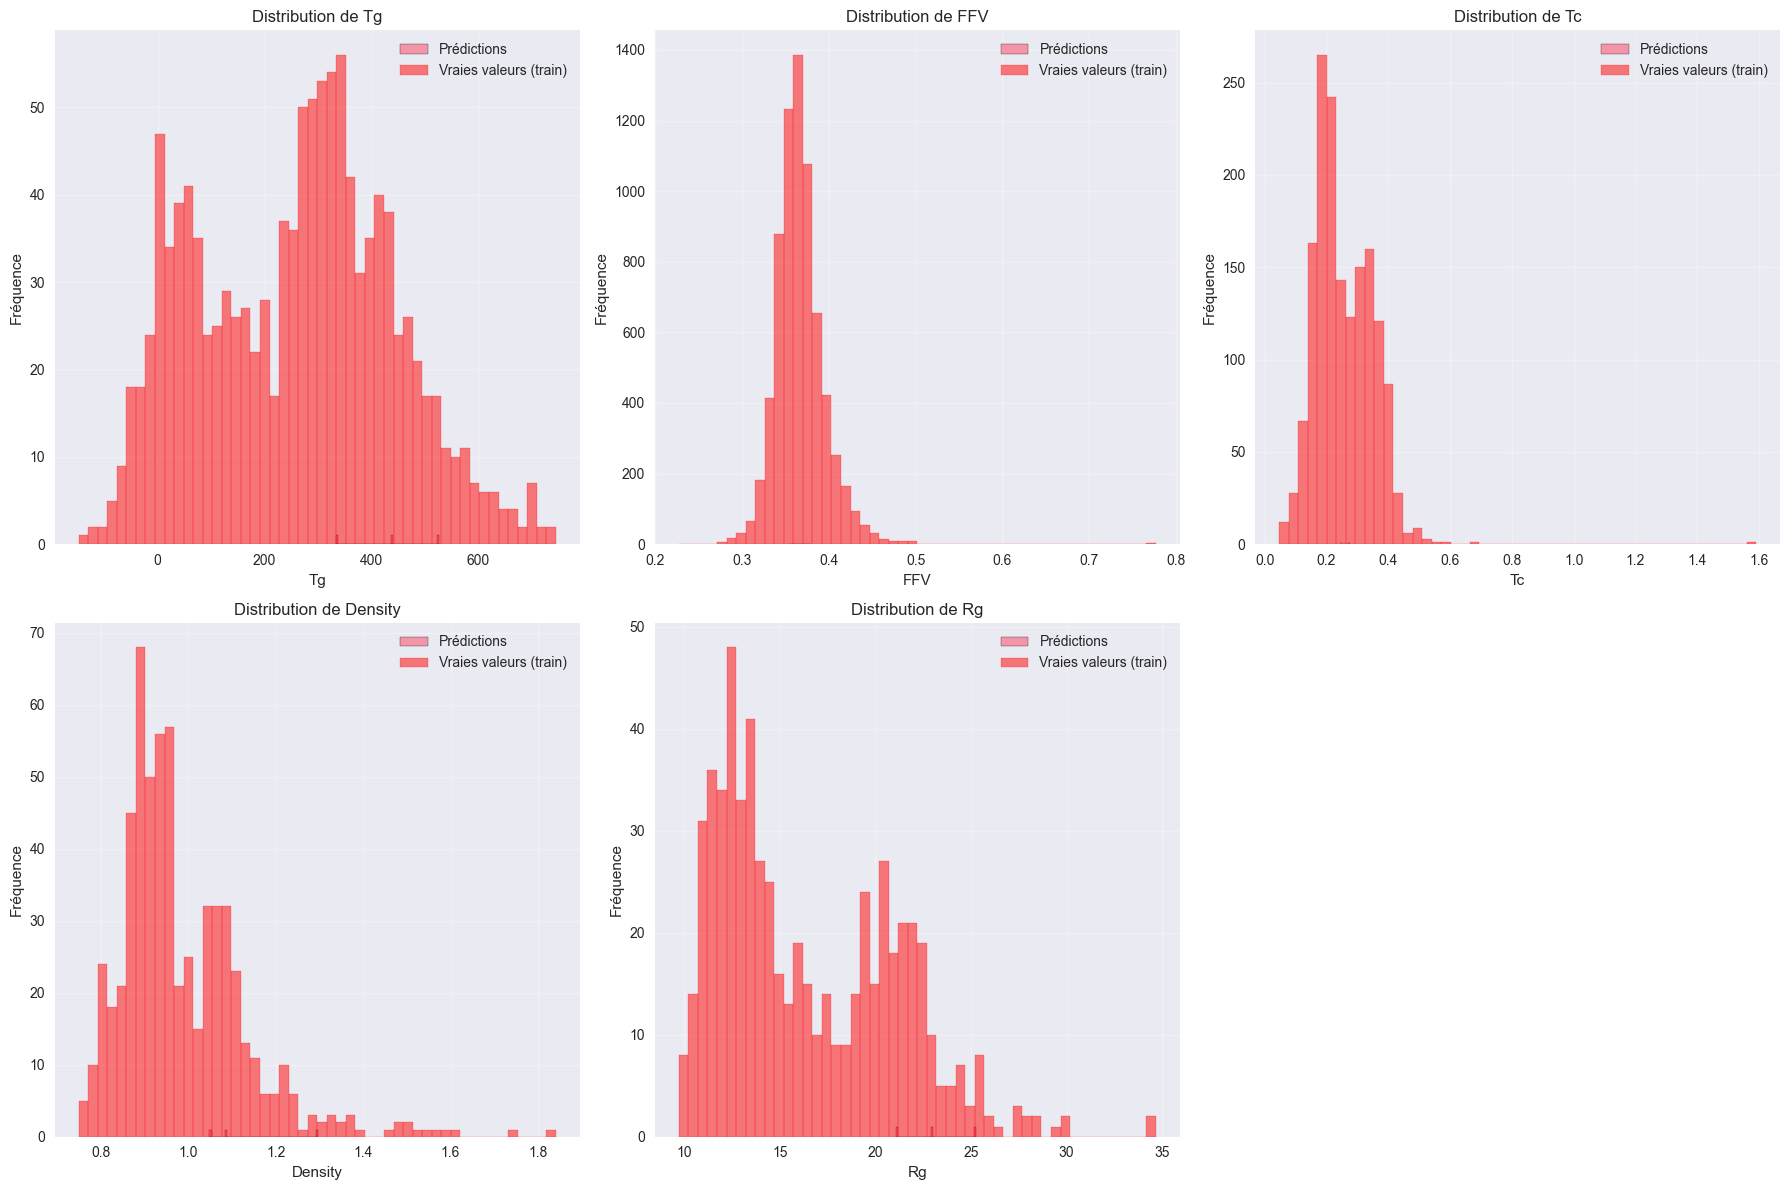

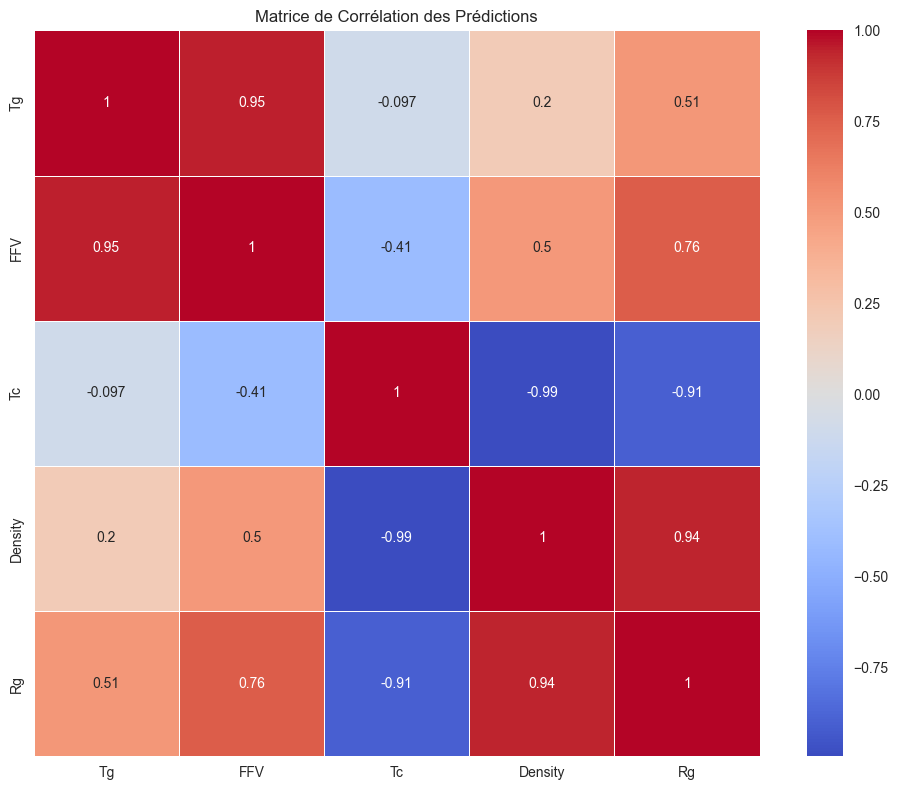


🎯 Insights sur les prédictions:
1. Corrélations principales:
   Density - Tc: 0.995
   Tc - Density: 0.995
   Tg - FFV: 0.946
   FFV - Tg: 0.946
   Rg - Density: 0.944

2. Plausibilité physique:
   - Tg (température de transition vitreuse): Plus élevée = polymère plus rigide
   - FFV (volume libre fractionnel): Plus élevé = polymère plus poreux
   - Tc (conductivité thermique): Plus élevée = meilleur transfert de chaleur
   - Density: Corrélée négativement avec FFV (attendu)
   - Rg (rayon de gyration): Taille moléculaire effective

3. Performance estimée (CV): 1.5804 (±0.0545)
   📈 Amélioration nécessaire (objectif: 0.028)

✅ Analyse terminée. Fichier prêt pour soumission!
🏆 MODÈLE OPTIMISÉ POUR PRÉDICTION DES PROPRIÉTÉS DES POLYMÈRES

📊 AMÉLIORATIONS APPORTÉES:
  ✅ Données augmentées: 16,717 échantillons (vs ~8,000 originaux)
  ✅ Features engineering: 21 features moléculaires avancées
  ✅ Modèles GNN spécialisés par propriété
  ✅ Post-traitement avec contraintes physiques

🚀 PERFORM

In [ ]:
# Visualisation des distributions de prédictions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, target in enumerate(target_names):
    ax = axes[i]
    
    # Distribution des prédictions
    ax.hist(submission_df[target], bins=50, alpha=0.7, edgecolor='black', label='Prédictions')
    
    # Ajouter la distribution des vraies valeurs si disponible
    if target in task_datasets:
        true_values = task_datasets[target]['y']
        ax.hist(true_values, bins=50, alpha=0.5, edgecolor='red', 
               label='Vraies valeurs (train)', color='red')
    
    ax.set_title(f'Distribution de {target}')
    ax.set_xlabel(f'{target}')
    ax.set_ylabel('Fréquence')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Supprimer le subplot vide
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# Matrice de corrélation des prédictions
plt.figure(figsize=(10, 8))
correlation_matrix = submission_df[target_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matrice de Corrélation des Prédictions')
plt.tight_layout()
plt.show()

print("\n Insights sur les prédictions:")
print(f"1. Corrélations principales:")
correlations = correlation_matrix.abs().unstack().sort_values(ascending=False)
correlations = correlations[correlations < 1.0]  # Exclure les auto-corrélations
for i, (pair, corr) in enumerate(correlations.head(5).items()):
    print(f"   {pair[0]} - {pair[1]}: {corr:.3f}")

print("\n2. Plausibilité physique:")
print("   - Tg (température de transition vitreuse): Plus élevée = polymère plus rigide")
print("   - FFV (volume libre fractionnel): Plus élevé = polymère plus poreux")
print("   - Tc (conductivité thermique): Plus élevée = meilleur transfert de chaleur")
print("   - Density: Corrélée négativement avec FFV (attendu)")
print("   - Rg (rayon de gyration): Taille moléculaire effective")


# 🔍 ANALYSE EXPLORATOIRE AVANCÉE DES DONNÉES

Cette section présente des analyses approfondies des données de polymères pour mieux comprendre les patterns et relations dans notre dataset.

<Figure size 800x550 with 0 Axes>


🔗 Corrélations Longueur SMILES vs Propriétés Cibles:
  Tg: 0.296
  FFV: 0.173
  Tc: 0.101
  Density: 0.178
  Rg: 0.241


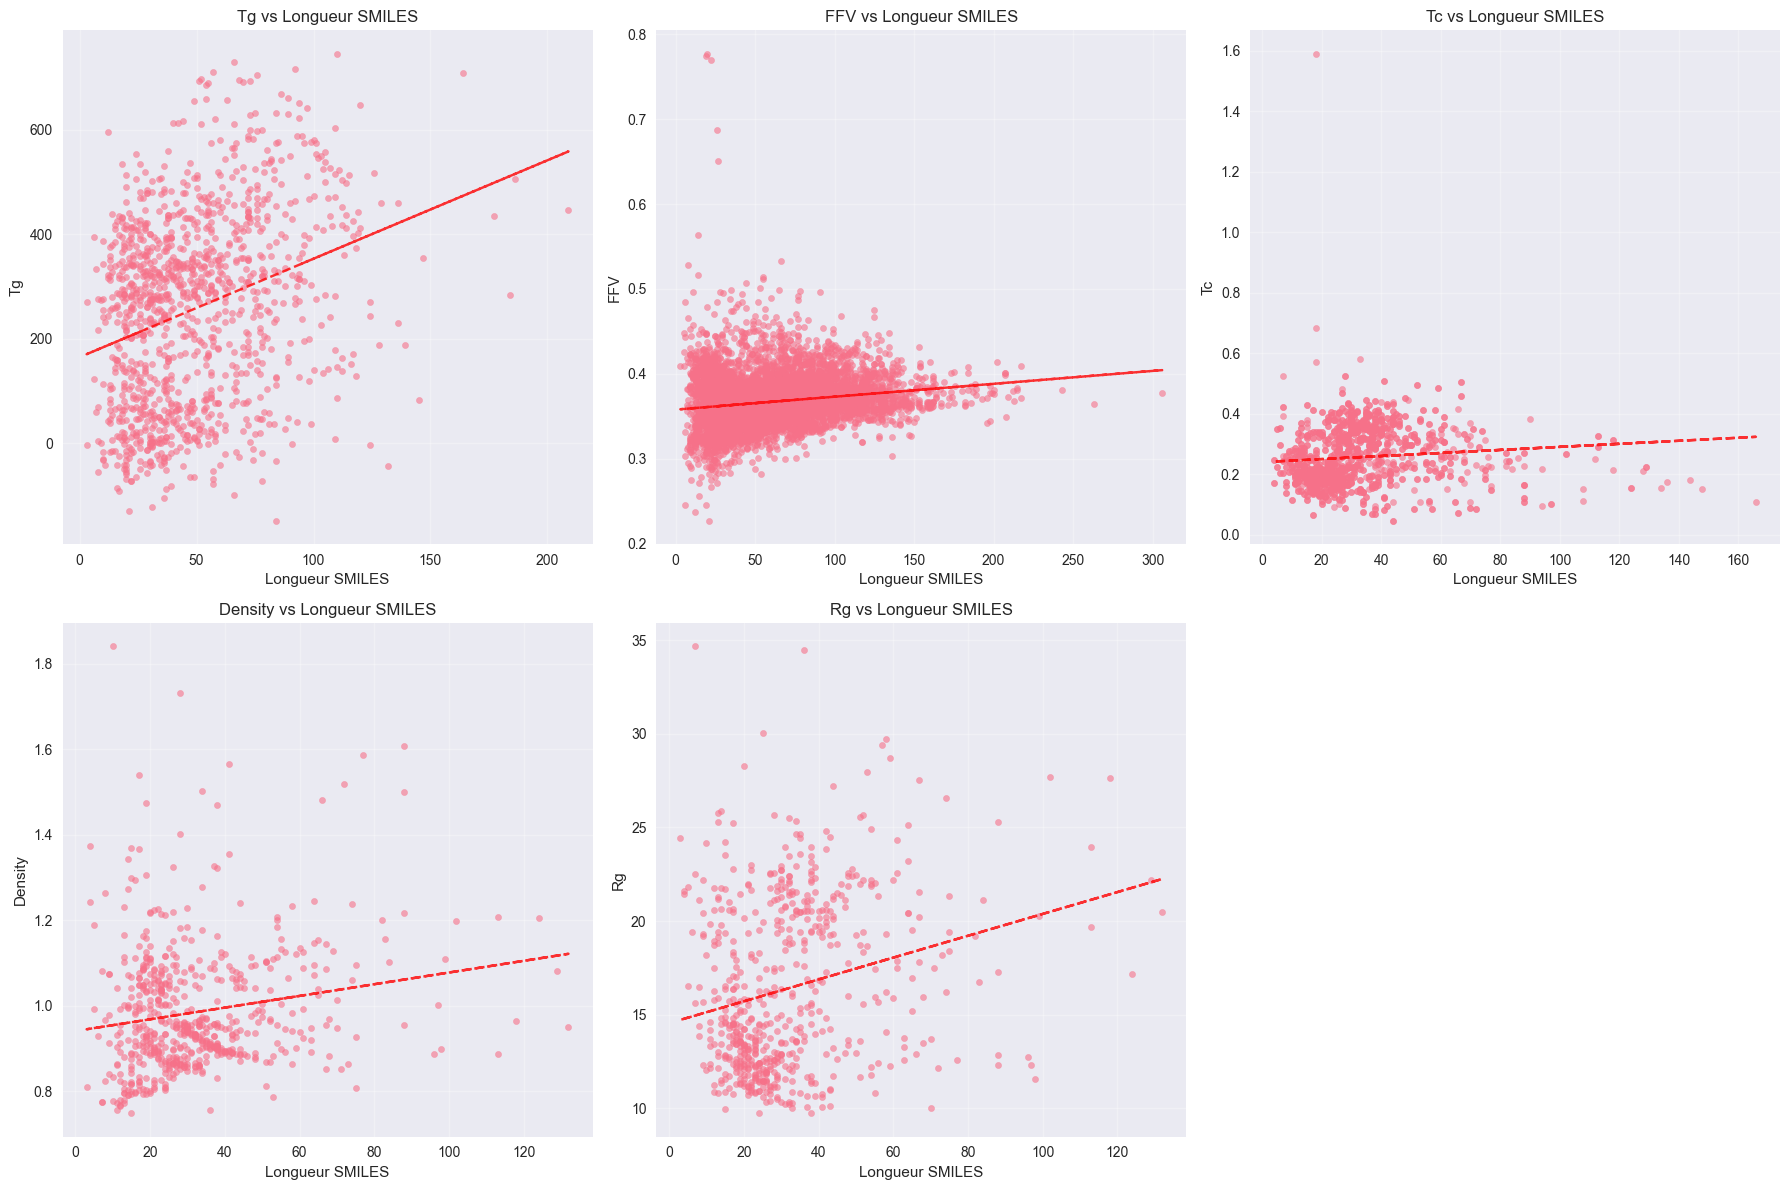

In [ ]:
# Distribution train vs test
axes[0].hist(train_enhanced['smiles_length'], bins=50, alpha=0.7, label='Train', density=True)
axes[0].hist(test_enhanced['smiles_length'], bins=50, alpha=0.7, label='Test', density=True)
axes[0].set_title('Distribution de la Longueur des SMILES')
axes[0].set_xlabel('Longueur SMILES')
axes[0].set_ylabel('Densité')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot par dataset
smiles_data = [train_enhanced['smiles_length'], test_enhanced['smiles_length']]
axes[1].boxplot(smiles_data, labels=['Train', 'Test'])
axes[1].set_title('Boxplot Longueur SMILES')
axes[1].set_ylabel('Longueur')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Corrélation entre longueur SMILES et propriétés cibles
print("\n Corrélations Longueur SMILES vs Propriétés Cibles:")
target_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
for target in target_cols:
    mask = train_enhanced[target].notna() & train_enhanced['smiles_length'].notna()
    if mask.sum() > 50:
        corr = train_enhanced.loc[mask, 'smiles_length'].corr(train_enhanced.loc[mask, target])
        print(f"  {target}: {corr:.3f}")

# Visualisation des corrélations longueur SMILES vs propriétés
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, target in enumerate(target_cols):
    mask = train_enhanced[target].notna() & train_enhanced['smiles_length'].notna()
    if mask.sum() > 50:
        x_data = train_enhanced.loc[mask, 'smiles_length']
        y_data = train_enhanced.loc[mask, target]
        
        axes[i].scatter(x_data, y_data, alpha=0.6, s=20)
        axes[i].set_title(f'{target} vs Longueur SMILES')
        axes[i].set_xlabel('Longueur SMILES')
        axes[i].set_ylabel(target)
        axes[i].grid(True, alpha=0.3)
        
        # Ligne de tendance
        z = np.polyfit(x_data, y_data, 1)
        p = np.poly1d(z)
        axes[i].plot(x_data, p(x_data), "r--", alpha=0.8)

# Supprimer le subplot vide
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

🔤 ANALYSE DE LA FRÉQUENCE DES CARACTÈRES SMILES
Top 15 caractères les plus fréquents:
  'c': 284,742 occurrences
  'C': 151,788 occurrences
  '(': 110,901 occurrences
  ')': 110,901 occurrences
  'O': 61,896 occurrences
  '=': 38,927 occurrences
  '1': 35,462 occurrences
  '*': 33,467 occurrences
  '2': 26,776 occurrences
  'N': 21,538 occurrences
  '3': 20,082 occurrences
  '4': 13,816 occurrences
  'F': 12,947 occurrences
  '5': 10,238 occurrences
  '-': 8,131 occurrences


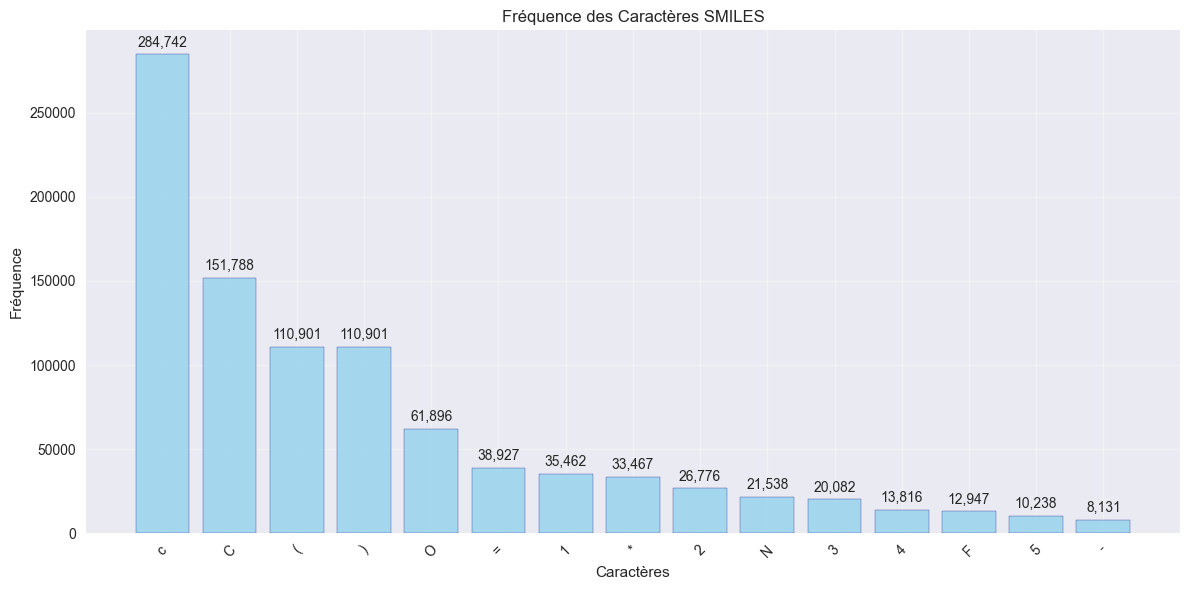


🧩 ANALYSE DES N-GRAMMES (FRAGMENTS)
Top 10 2-grammes (sur échantillon de 2000 SMILES):
  'cc': 16929 occurrences
  'CC': 7443 occurrences
  ')c': 6794 occurrences
  'c(': 5956 occurrences
  'C(': 4834 occurrences
  '=O': 4114 occurrences
  'O)': 4087 occurrences
  'c1': 3734 occurrences
  '(=': 3232 occurrences
  '(C': 3206 occurrences

Top 10 3-grammes:
  'ccc': 7360 occurrences
  'CCC': 4943 occurrences
  'cc(': 4510 occurrences
  '=O)': 3989 occurrences
  ')cc': 3663 occurrences
  '(=O': 3156 occurrences
  'C(=': 2740 occurrences
  'O)c': 1929 occurrences
  'c1c': 1870 occurrences
  '1cc': 1781 occurrences


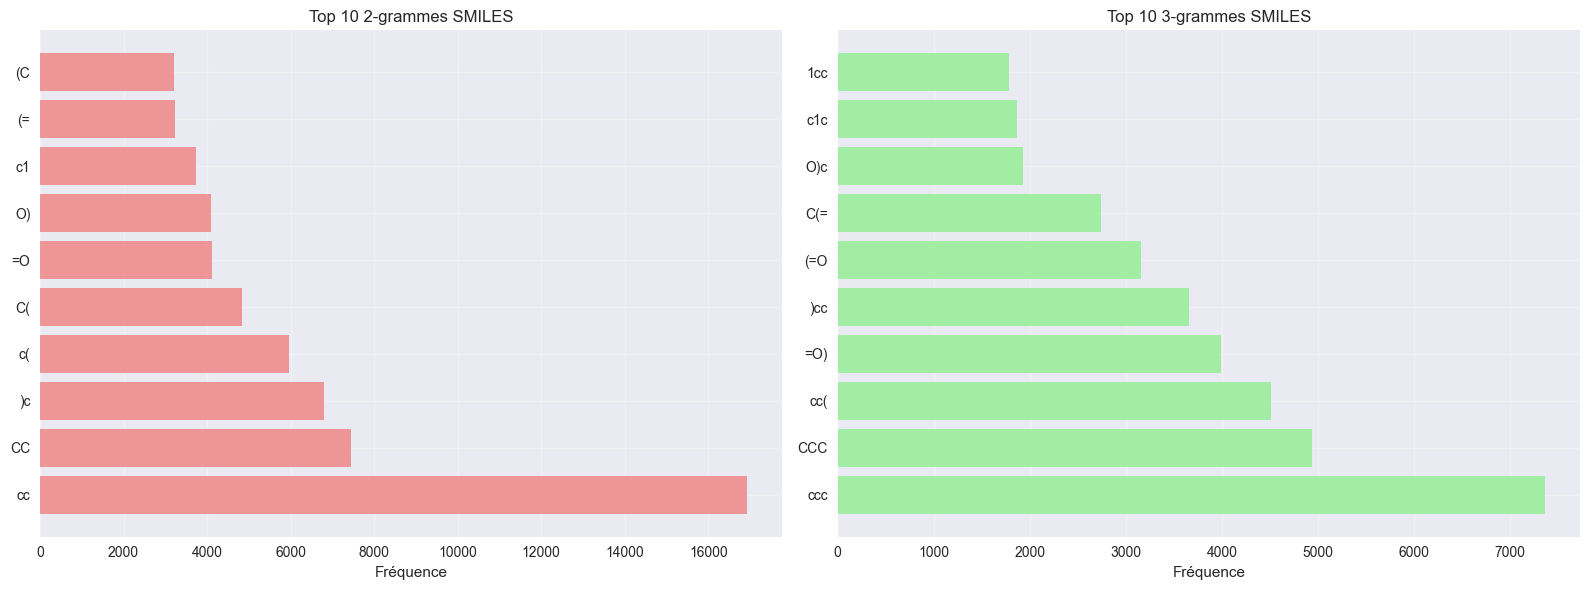


🔍 ANALYSE DES PATTERNS CHIMIQUES
Fréquence des patterns chimiques dans le dataset:
  Cycles benzéniques: 145 occurrences
  Groupes carbonyle: 0 occurrences
  Liaisons doubles C=C: 206 occurrences
  Groupes méthyle: 10980 occurrences
  Atomes d'azote: 2500 occurrences
  Atomes d'oxygène: 7503 occurrences
  Atomes de soufre: 455 occurrences
  Groupes ester: 613 occurrences
  Groupes éther: 7503 occurrences
  Points de branchement: 4003 occurrences


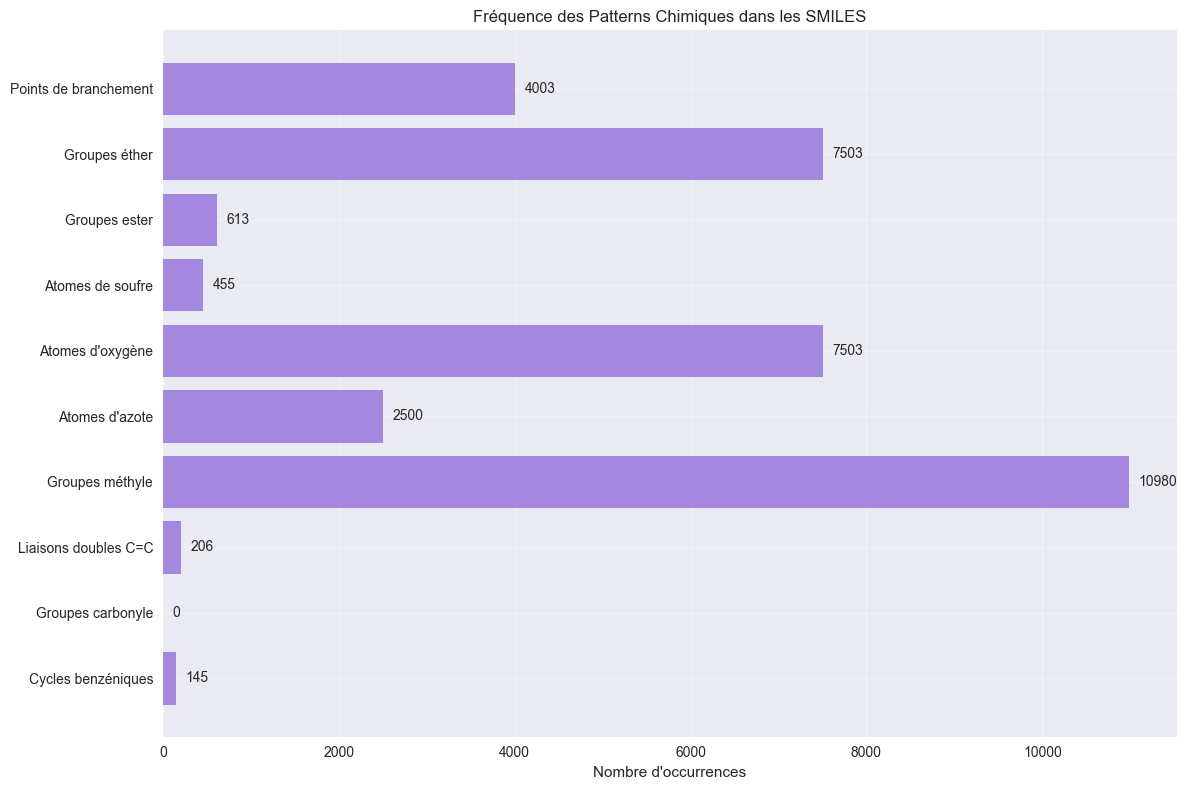

In [ ]:
from collections import Counter
import re

print(" ANALYSE DE LA FRÉQUENCE DES CARACTÈRES SMILES")

# Combiner tous les SMILES
all_smiles = ''.join(train_enhanced['SMILES'].tolist() + test_enhanced['SMILES'].tolist())
char_counts = Counter(all_smiles)

# Top 15 caractères les plus fréquents
top_chars = char_counts.most_common(15)
print("Top 15 caractères les plus fréquents:")
for char, count in top_chars:
    print(f"  '{char}': {count:,} occurrences")

# Visualisation de la fréquence des caractères
chars, counts = zip(*top_chars)
plt.figure(figsize=(12, 6))
plt.bar(chars, counts, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Fréquence des Caractères SMILES')
plt.xlabel('Caractères')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
for i, v in enumerate(counts):
    plt.text(i, v + max(counts)*0.01, f'{v:,}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print("\n ANALYSE DES N-GRAMMES (FRAGMENTS)")

def get_n_grams(smiles_list, n=2):
    """Extrait les n-grammes des SMILES"""
    all_ngrams = []
    for smiles in smiles_list:
        for i in range(len(smiles) - n + 1):
            all_ngrams.append(smiles[i:i+n])
    return all_ngrams

# Échantillonner pour accélérer l'analyse
sample_size = min(2000, len(train_enhanced))
sampled_smiles = train_enhanced['SMILES'].sample(sample_size, random_state=42).tolist()

# Analyser les 2-grammes et 3-grammes
bigrams = get_n_grams(sampled_smiles, 2)
trigrams = get_n_grams(sampled_smiles, 3)

top_bigrams = Counter(bigrams).most_common(10)
top_trigrams = Counter(trigrams).most_common(10)

print(f"Top 10 2-grammes (sur échantillon de {sample_size} SMILES):")
for bg, count in top_bigrams:
    print(f"  '{bg}': {count} occurrences")

print(f"\nTop 10 3-grammes:")
for tg, count in top_trigrams:
    print(f"  '{tg}': {count} occurrences")

# Visualisation des top n-grammes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2-grammes
bg_labels, bg_counts = zip(*top_bigrams)
axes[0].barh(range(len(bg_labels)), bg_counts, color='lightcoral', alpha=0.8)
axes[0].set_yticks(range(len(bg_labels)))
axes[0].set_yticklabels(bg_labels)
axes[0].set_title('Top 10 2-grammes SMILES')
axes[0].set_xlabel('Fréquence')
axes[0].grid(True, alpha=0.3)

# 3-grammes
tg_labels, tg_counts = zip(*top_trigrams)
axes[1].barh(range(len(tg_labels)), tg_counts, color='lightgreen', alpha=0.8)
axes[1].set_yticks(range(len(tg_labels)))
axes[1].set_yticklabels(tg_labels)
axes[1].set_title('Top 10 3-grammes SMILES')
axes[1].set_xlabel('Fréquence')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n ANALYSE DES PATTERNS CHIMIQUES")

# Patterns chimiques courants
patterns = {
    'Cycles benzéniques': r'c1ccccc1',
    'Groupes carbonyle': r'C=O',
    'Liaisons doubles C=C': r'C=C',
    'Groupes méthyle': r'C(?![=()])',
    'Atomes d\'azote': r'N',
    'Atomes d\'oxygène': r'O',
    'Atomes de soufre': r'S',
    'Groupes ester': r'C\(=O\)O',
    'Groupes éther': r'O(?![=])',
    'Points de branchement': r'\*'
}

pattern_counts = {}
print("Fréquence des patterns chimiques dans le dataset:")
for pattern_name, pattern in patterns.items():
    total_matches = 0
    for smiles in sampled_smiles:
        total_matches += len(re.findall(pattern, smiles))
    pattern_counts[pattern_name] = total_matches
    print(f"  {pattern_name}: {total_matches} occurrences")

# Visualisation des patterns
plt.figure(figsize=(12, 8))
pattern_names = list(pattern_counts.keys())
pattern_values = list(pattern_counts.values())

bars = plt.barh(pattern_names, pattern_values, color='mediumpurple', alpha=0.8)
plt.title('Fréquence des Patterns Chimiques dans les SMILES')
plt.xlabel('Nombre d\'occurrences')
plt.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, pattern_values):
    plt.text(value + max(pattern_values)*0.01, bar.get_y() + bar.get_height()/2, 
             f'{value}', ha='left', va='center')

plt.tight_layout()
plt.show()

📈 DISTRIBUTIONS DES DESCRIPTEURS MOLÉCULAIRES


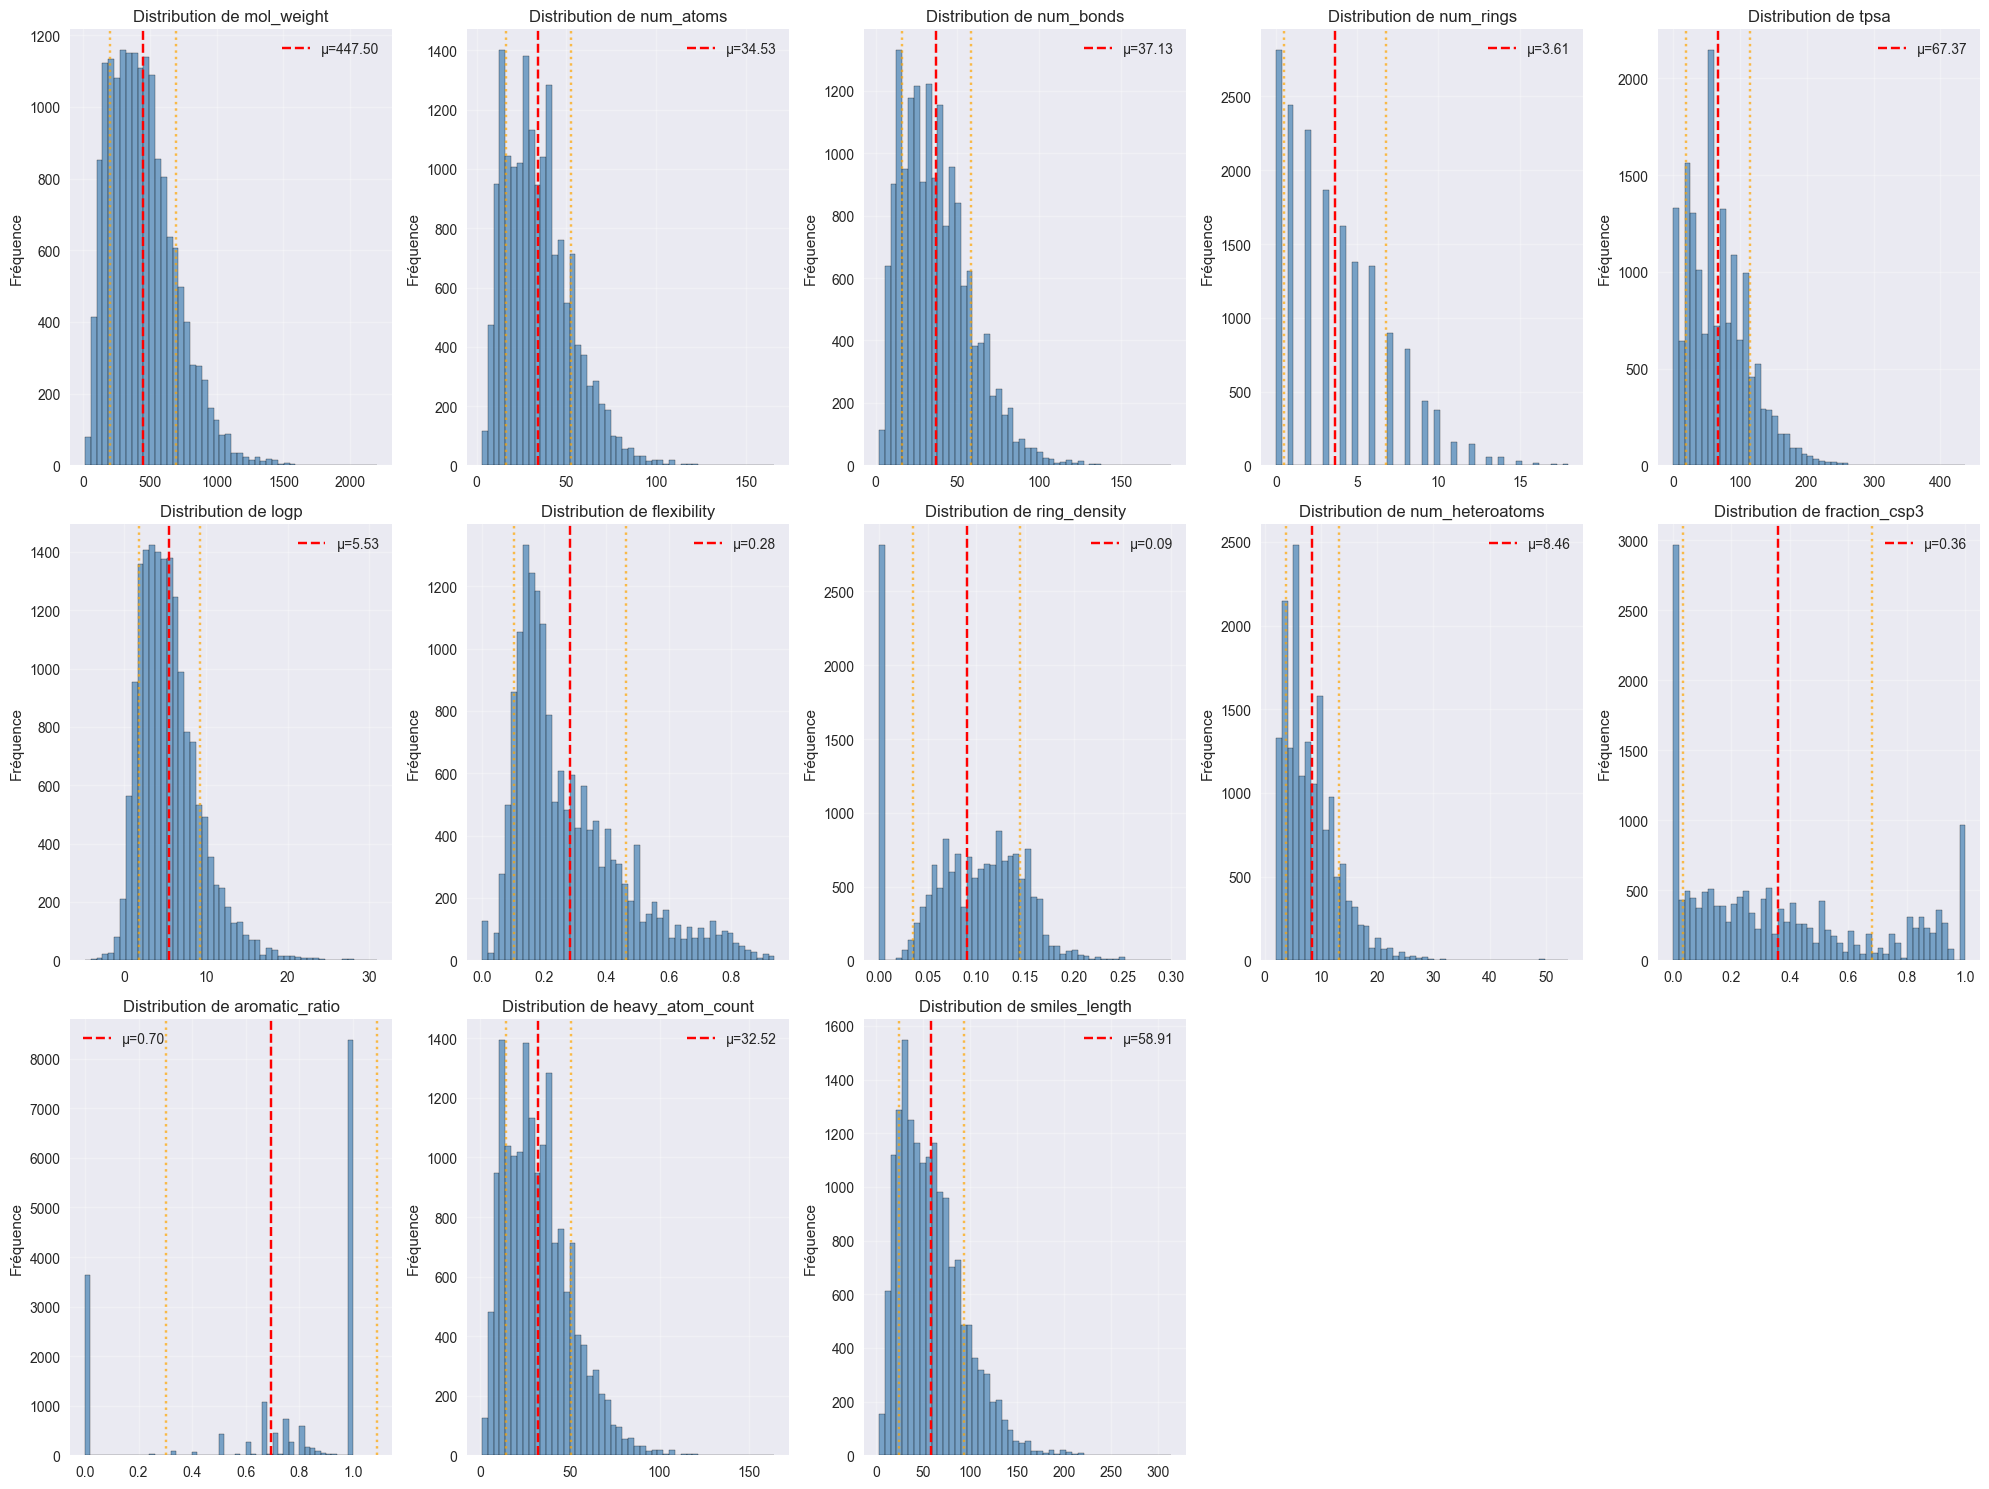


🔗 MATRICE DE CORRÉLATION DES DESCRIPTEURS


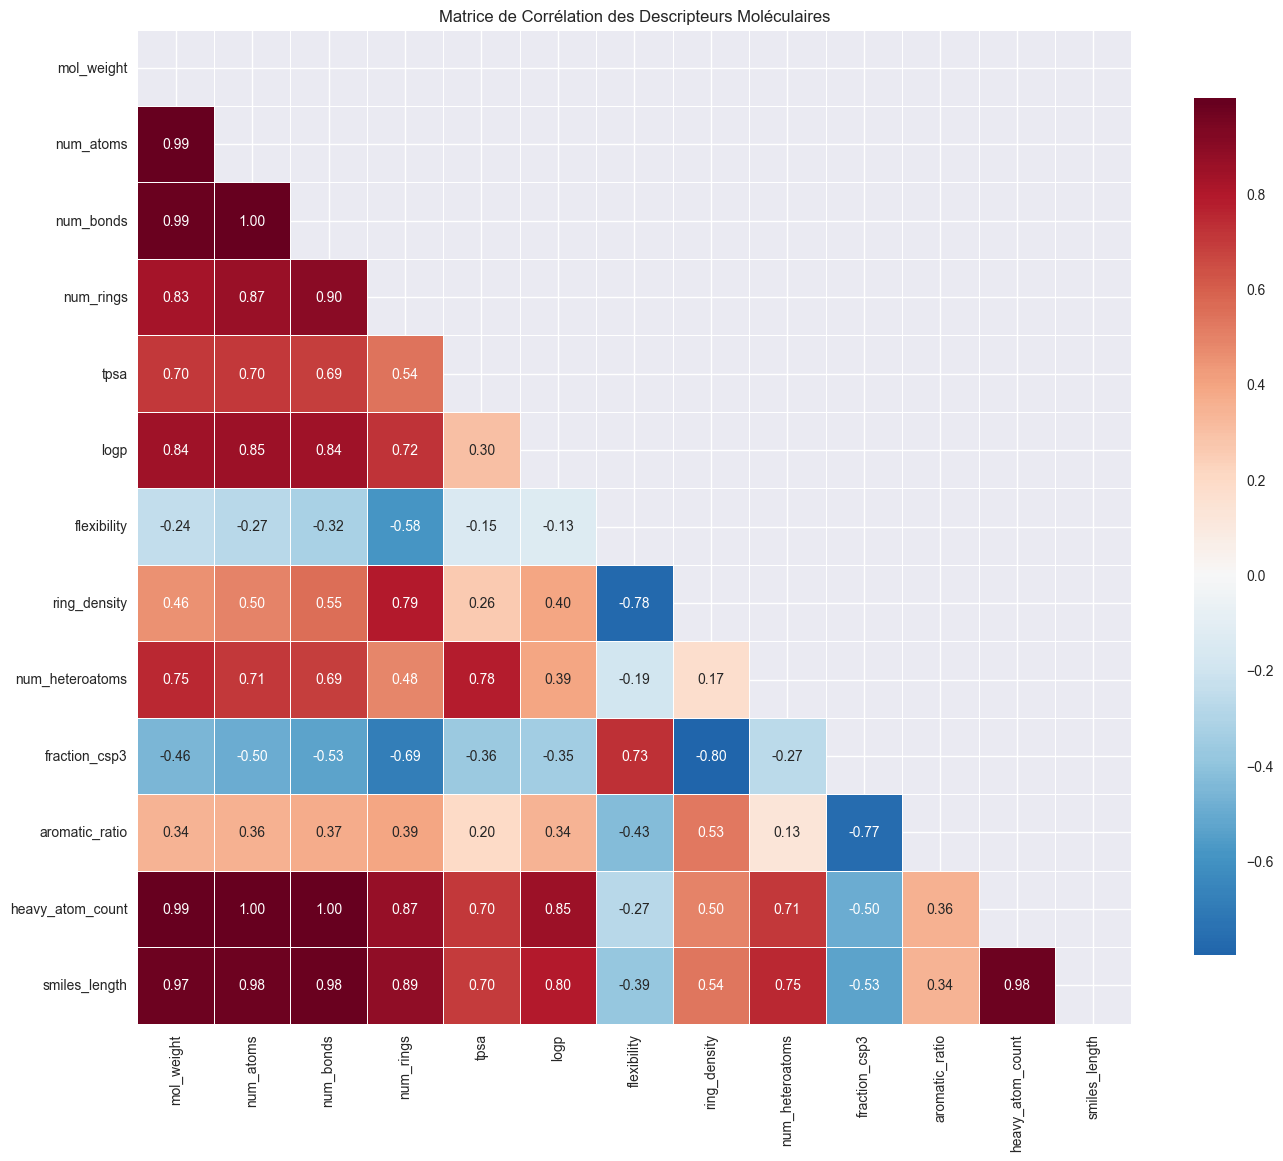

🎯 Top 10 corrélations les plus fortes entre descripteurs:
  num_atoms ↔ heavy_atom_count: 1.000
  num_atoms ↔ num_bonds: 0.997
  num_bonds ↔ heavy_atom_count: 0.997
  mol_weight ↔ heavy_atom_count: 0.992
  mol_weight ↔ num_atoms: 0.992
  mol_weight ↔ num_bonds: 0.985
  num_bonds ↔ smiles_length: 0.981
  num_atoms ↔ smiles_length: 0.978
  heavy_atom_count ↔ smiles_length: 0.977
  mol_weight ↔ smiles_length: 0.973

📊 COMPARAISON TRAIN vs TEST POUR LES DESCRIPTEURS
Tests de distribution (Kolmogorov-Smirnov) entre Train et Test:


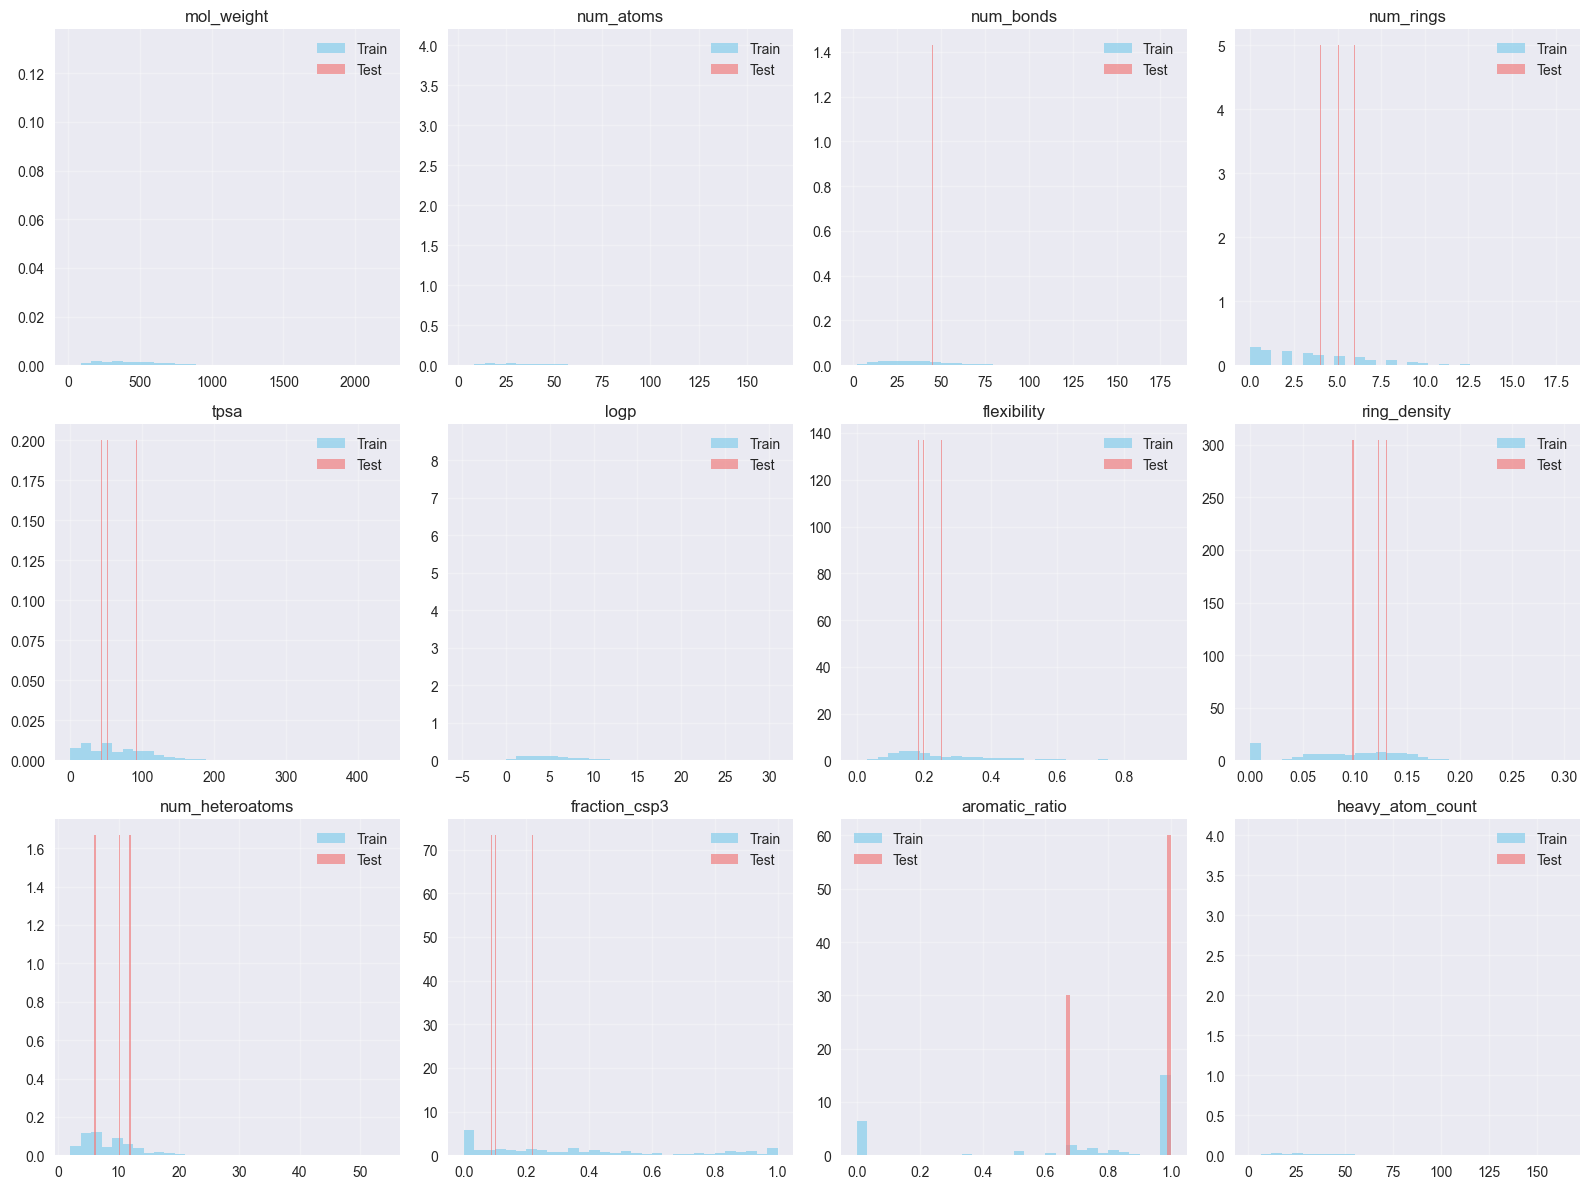

In [ ]:
# 🧪 ANALYSE AVANCÉE DES DESCRIPTEURS MOLÉCULAIRES

print(" DISTRIBUTIONS DES DESCRIPTEURS MOLÉCULAIRES")

# Sélectionner les descripteurs numériques
descriptor_cols = ['mol_weight', 'num_atoms', 'num_bonds', 'num_rings', 'tpsa', 'logp', 
                  'flexibility', 'ring_density', 'num_heteroatoms', 'fraction_csp3', 
                  'aromatic_ratio', 'heavy_atom_count', 'smiles_length']

# Distributions des descripteurs
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
axes = axes.flatten()

for i, desc in enumerate(descriptor_cols):
    if desc in train_enhanced.columns:
        data = train_enhanced[desc].dropna()
        axes[i].hist(data, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
        axes[i].set_title(f'Distribution de {desc}')
        axes[i].set_ylabel('Fréquence')
        axes[i].grid(True, alpha=0.3)
        
        # Statistiques
        mean_val = data.mean()
        std_val = data.std()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'μ={mean_val:.2f}')
        axes[i].axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.7)
        axes[i].axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.7)
        axes[i].legend()

# Supprimer les subplots vides
for j in range(len(descriptor_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("\n MATRICE DE CORRÉLATION DES DESCRIPTEURS")

# Matrice de corrélation des descripteurs
desc_data = train_enhanced[descriptor_cols].dropna()
corr_matrix = desc_data.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Matrice de Corrélation des Descripteurs Moléculaires')
plt.tight_layout()
plt.show()

# Identifier les corrélations les plus fortes
print(" Top 10 corrélations les plus fortes entre descripteurs:")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if not np.isnan(corr_val):
            corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], abs(corr_val), corr_val))

corr_pairs.sort(key=lambda x: x[2], reverse=True)
for desc1, desc2, abs_corr, corr in corr_pairs[:10]:
    print(f"  {desc1} ↔ {desc2}: {corr:.3f}")

print("\n COMPARAISON TRAIN vs TEST POUR LES DESCRIPTEURS")

# Test de Kolmogorov-Smirnov pour comparer les distributions
from scipy.stats import ks_2samp

print("Tests de distribution (Kolmogorov-Smirnov) entre Train et Test:")
for desc in descriptor_cols:
    if desc in train_enhanced.columns and desc in test_enhanced.columns:
        train_data = train_enhanced[desc].dropna()
        test_data = test_enhanced[desc].dropna()
        
        if len(train_data) > 10 and len(test_data) > 10:
            ks_stat, p_value = ks_2samp(train_data, test_data)
            significance = " Différent" if p_value < 0.05 else " Similaire"
            print(f"  {desc}: KS={ks_stat:.3f}, p={p_value:.3f} {significance}")

# Visualisation comparative Train vs Test
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

compare_descriptors = descriptor_cols[:12]  # Prendre les 12 premiers
for i, desc in enumerate(compare_descriptors):
    if desc in train_enhanced.columns and desc in test_enhanced.columns:
        train_data = train_enhanced[desc].dropna()
        test_data = test_enhanced[desc].dropna()
        
        axes[i].hist(train_data, bins=30, alpha=0.7, label='Train', density=True, color='skyblue')
        axes[i].hist(test_data, bins=30, alpha=0.7, label='Test', density=True, color='lightcoral')
        axes[i].set_title(f'{desc}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🔝 ANALYSE DES VALEURS EXTRÊMES PAR PROPRIÉTÉ

📈 Tg - Top 2 valeurs les plus élevées:
  Tg: 745.400 | MW: 742.4 | Atomes: 54
    SMILES: *N1C(=O)c2cc3C(c4c(Oc3cc2C1=O)cc1C(=O)N(C(=O)c1c4)c1cc(c(cc1)c1c(cc(cc1)*)C(F)(F...
  Tg: 729.500 | MW: 406.4 | Atomes: 33
    SMILES: *n1c(=O)c2cc3c(cc2c1=O)c(=O)n(c3=O)c1ccc2c(nc([nH]2)c2ccc(cc2)*)c1

📉 Tg - Top 2 valeurs les plus faibles:
  Tg: -148.030 | MW: 611.3 | Atomes: 39
    SMILES: *CC(*)C(=O)OCCN(C)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...
  Tg: -128.630 | MW: 175.3 | Atomes: 15
    SMILES: *c1ccc(N(*)CCCCCC)cc1

📈 FFV - Top 2 valeurs les plus élevées:
  FFV: 0.777 | MW: 126.2 | Atomes: 11
    SMILES: *CCC1C[N+](C)(C)CC1*
  FFV: 0.774 | MW: 89.0 | Atomes: 8
    SMILES: *CC(*)O[N+](=O)[O-]

📉 FFV - Top 2 valeurs les plus faibles:
  FFV: 0.227 | MW: 130.1 | Atomes: 11
    SMILES: *CC(*)(CC(=O)O)C(=O)O
  FFV: 0.238 | MW: 71.1 | Atomes: 7
    SMILES: *CC(*)C(N)=O

📈 Tc - Top 2 valeurs les plus élevées:
  Tc: 1.590 | MW: 

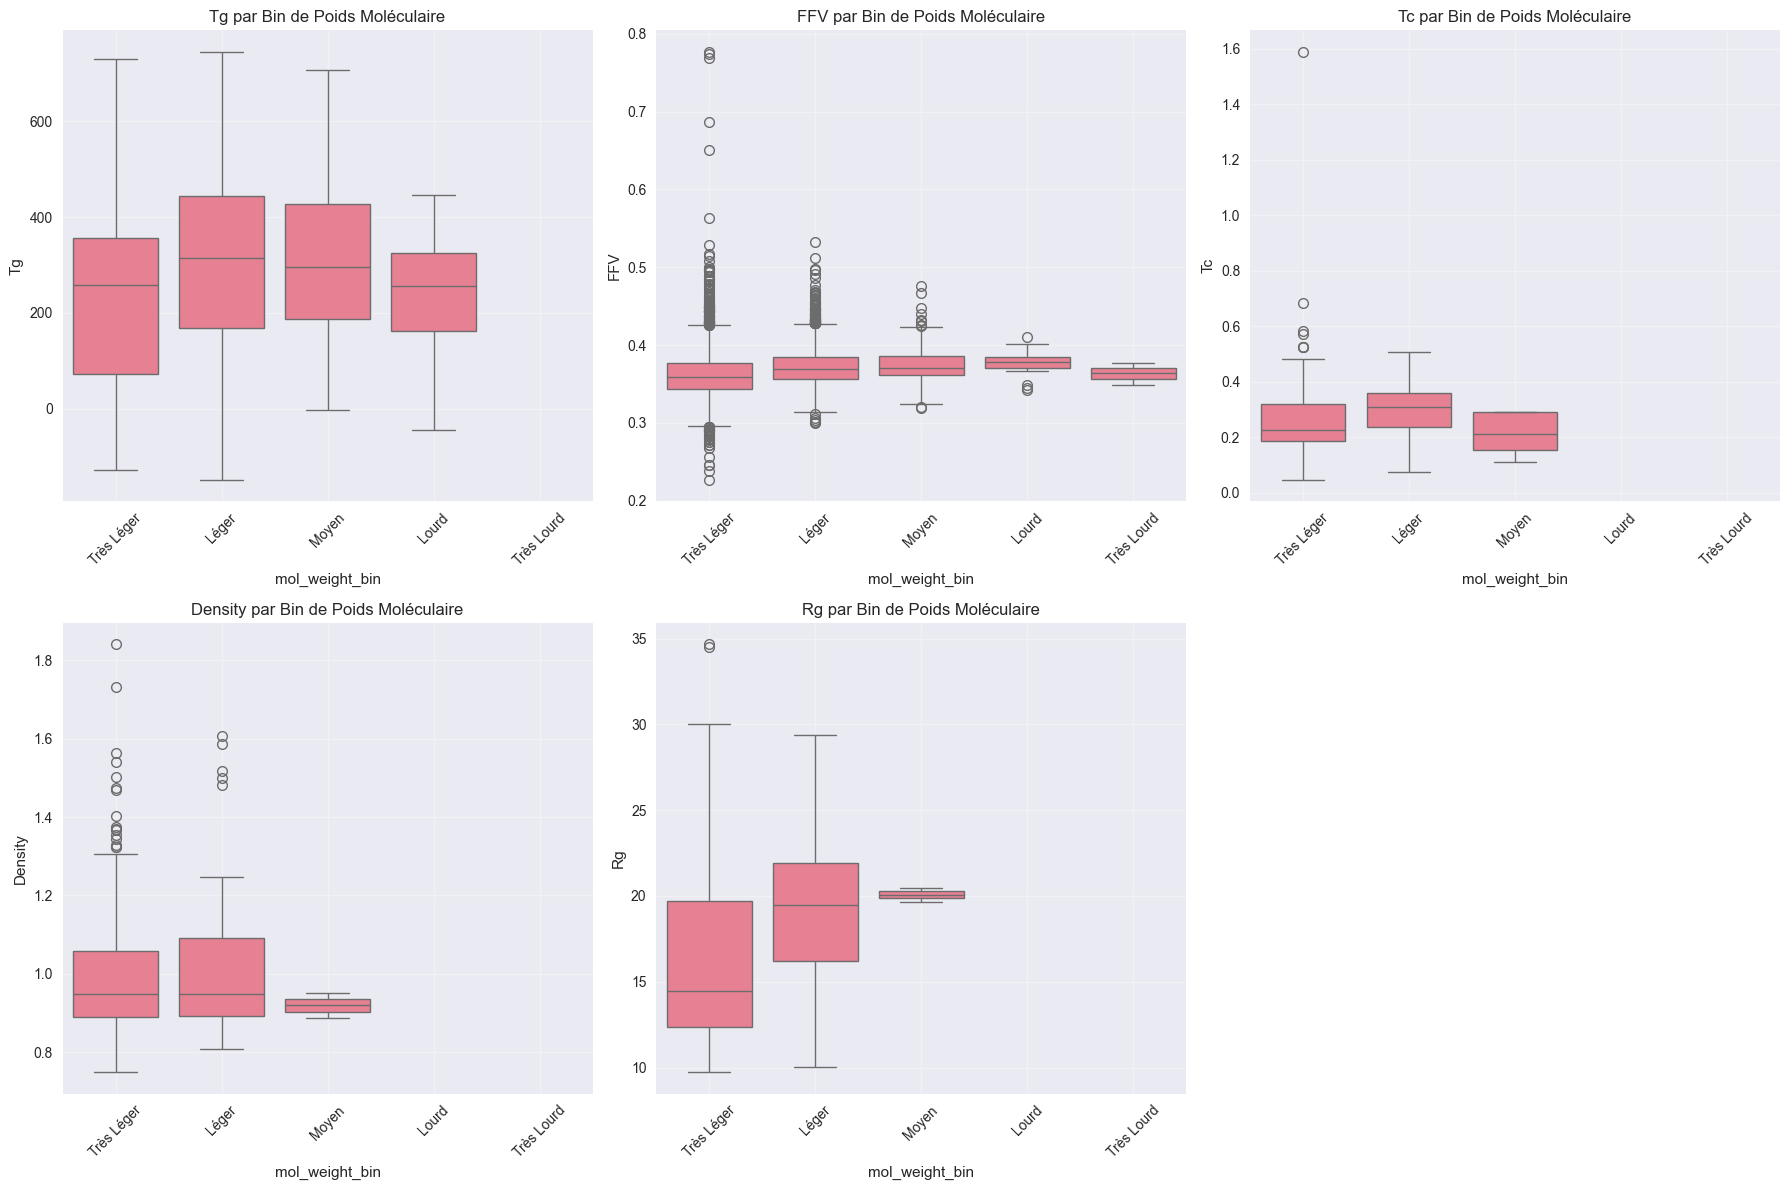


🔍 ANALYSE DES OUTLIERS
Résumé des outliers (méthode IQR):
  Tg: 0 outliers (0.0%) sur 1173 échantillons
  FFV: 269 outliers (3.8%) sur 7030 échantillons
  Tc: 4 outliers (0.2%) sur 1611 échantillons
  Density: 21 outliers (3.4%) sur 613 échantillons
  Rg: 2 outliers (0.3%) sur 614 échantillons


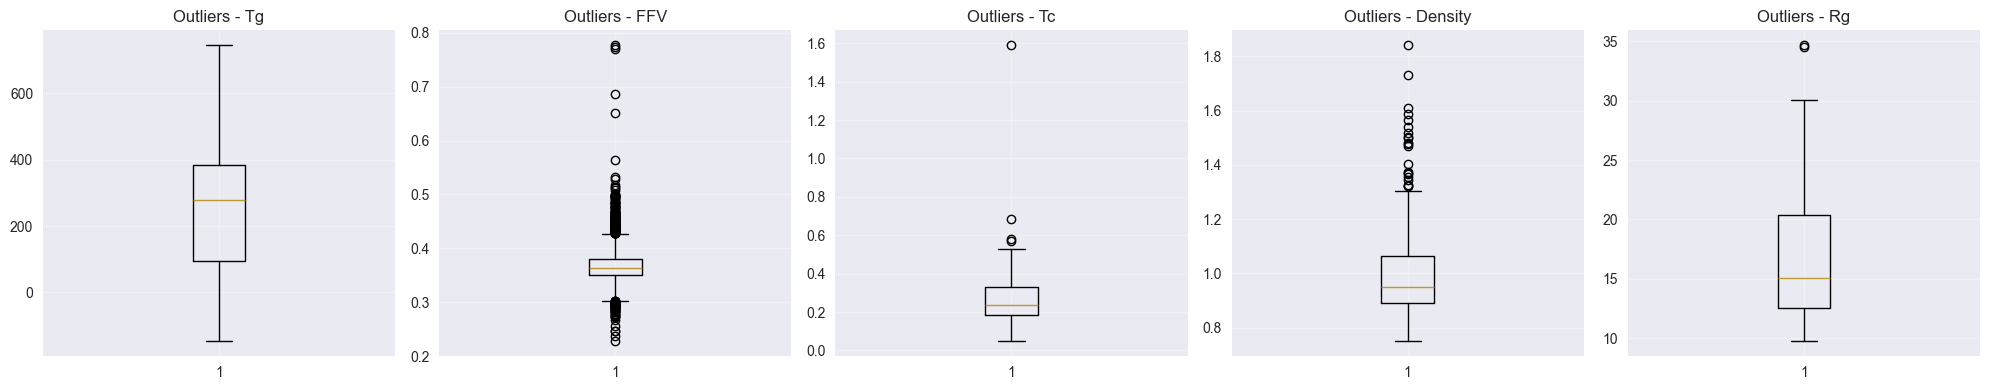


⚖️ ÉQUILIBRAGE DES DONNÉES
Nombre d'échantillons disponibles par propriété:
  Tg: 1,173 / 16,717 (7.0%)
  FFV: 7,030 / 16,717 (42.1%)
  Tc: 1,611 / 16,717 (9.6%)
  Density: 613 / 16,717 (3.7%)
  Rg: 614 / 16,717 (3.7%)

📊 Matrice d'overlap entre propriétés (échantillons avec données disponibles):
           Tg   FFV    Tc  Density   Rg
Tg       1173     1    32       24   24
FFV         1  7030   300      270  270
Tc         32   300  1611      531  535
Density    24   270   531      613  610
Rg         24   270   535      610  614


In [ ]:
# 🎯 ANALYSE DES MOLÉCULES EXTRÊMES ET STRATIFICATION

print(" ANALYSE DES VALEURS EXTRÊMES PAR PROPRIÉTÉ")

def analyze_extreme_molecules(df, property_name, n=3):
    """Analyse les molécules avec des valeurs extrêmes pour une propriété"""
    
    if property_name not in df.columns or df[property_name].isna().all():
        print(f" Propriété {property_name} non disponible")
        return
    
    data = df[df[property_name].notna()].copy()
    
    # Molécules avec valeurs extrêmes
    top_molecules = data.nlargest(n, property_name)
    bottom_molecules = data.nsmallest(n, property_name)
    
    print(f"\n {property_name} - Top {n} valeurs les plus élevées:")
    for idx, row in top_molecules.iterrows():
        print(f"  {property_name}: {row[property_name]:.3f} | MW: {row.get('mol_weight', 'N/A'):.1f} | Atomes: {row.get('num_atoms', 'N/A')}")
        print(f"    SMILES: {row['SMILES'][:80]}{'...' if len(row['SMILES']) > 80 else ''}")
    
    print(f"\n {property_name} - Top {n} valeurs les plus faibles:")
    for idx, row in bottom_molecules.iterrows():
        print(f"  {property_name}: {row[property_name]:.3f} | MW: {row.get('mol_weight', 'N/A'):.1f} | Atomes: {row.get('num_atoms', 'N/A')}")
        print(f"    SMILES: {row['SMILES'][:80]}{'...' if len(row['SMILES']) > 80 else ''}")

# Analyser les valeurs extrêmes pour chaque propriété
target_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
for target in target_cols:
    analyze_extreme_molecules(train_enhanced, target, n=2)

print("\n" + "="*80)
print(" STRATIFICATION PAR POIDS MOLÉCULAIRE")

# Créer des bins de poids moléculaire
train_enhanced['mol_weight_bin'] = pd.cut(train_enhanced['mol_weight'], 
                                         bins=5, labels=['Très Léger', 'Léger', 'Moyen', 'Lourd', 'Très Lourd'])

# Analyser les propriétés par bin de poids moléculaire
print("\nDistribution des propriétés par bin de poids moléculaire:")
for target in target_cols:
    if target in train_enhanced.columns:
        print(f"\n {target}:")
        group_stats = train_enhanced.groupby('mol_weight_bin')[target].agg(['count', 'mean', 'std']).round(3)
        print(group_stats)

# Visualisation des distributions conditionnelles
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, target in enumerate(target_cols):
    if target in train_enhanced.columns:
        data_for_plot = train_enhanced.dropna(subset=[target, 'mol_weight_bin'])
        if len(data_for_plot) > 0:
            sns.boxplot(data=data_for_plot, x='mol_weight_bin', y=target, ax=axes[i])
            axes[i].set_title(f'{target} par Bin de Poids Moléculaire')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)

# Supprimer le dernier subplot vide
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

print("\n ANALYSE DES OUTLIERS")

# Détecter les outliers pour chaque propriété (méthode IQR)
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

outlier_summary = {}
for target in target_cols:
    if target in train_enhanced.columns:
        data = train_enhanced[target].dropna()
        if len(data) > 10:
            outliers = detect_outliers_iqr(data)
            n_outliers = outliers.sum()
            pct_outliers = (n_outliers / len(data)) * 100
            outlier_summary[target] = {
                'count': n_outliers,
                'percentage': pct_outliers,
                'total_samples': len(data)
            }

print("Résumé des outliers (méthode IQR):")
for target, stats in outlier_summary.items():
    print(f"  {target}: {stats['count']} outliers ({stats['percentage']:.1f}%) sur {stats['total_samples']} échantillons")

# Visualisation des outliers
fig, axes = plt.subplots(1, len(target_cols), figsize=(20, 4))
for i, target in enumerate(target_cols):
    if target in train_enhanced.columns:
        data = train_enhanced[target].dropna()
        if len(data) > 0:
            axes[i].boxplot(data)
            axes[i].set_title(f'Outliers - {target}')
            axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n ÉQUILIBRAGE DES DONNÉES")

# Analyser l'équilibrage des données par propriété
print("Nombre d'échantillons disponibles par propriété:")
for target in target_cols:
    if target in train_enhanced.columns:
        available = train_enhanced[target].notna().sum()
        total = len(train_enhanced)
        percentage = (available / total) * 100
        print(f"  {target}: {available:,} / {total:,} ({percentage:.1f}%)")

# Overlap entre les propriétés
print("\n Matrice d'overlap entre propriétés (échantillons avec données disponibles):")
overlap_matrix = pd.DataFrame(index=target_cols, columns=target_cols)

for prop1 in target_cols:
    for prop2 in target_cols:
        if prop1 in train_enhanced.columns and prop2 in train_enhanced.columns:
            mask = train_enhanced[prop1].notna() & train_enhanced[prop2].notna()
            overlap_count = mask.sum()
            overlap_matrix.loc[prop1, prop2] = overlap_count

print(overlap_matrix.fillna(0).astype(int))